# Covid19 - Brazil (Cities) Basic Geographic Analysis
- by Marcelo Rovai
- 05 April 2020

## Main Libraries and setup

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from unicodedata import normalize
import datetime
date = datetime.datetime.today()

In [255]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.float_format', lambda x: '%.f' % x)
sns.set(context='paper', style='ticks', palette='inferno')
sns.mpl.rc("figure", figsize=(10, 6))
mpl.rcParams['figure.dpi']= 150

pd.options.display.float_format = '{:,}'.format

## Datasets

### Covid19

Confirmed cases by day, using information from the news. Covid19br dataset is available at GitHub https://github.com/wcota/covid19br. <br>
Thanks to [Wesley Cota](https://wesleycota.com), PhD candidate - Complex Networks/Physics (Universidade Federal de Viçosa - Brazil and Universidad de Zaragoza - Spain).

More information: https://wcota.me/covid19br

**Number of total cases by city** 

In [548]:
date = datetime.datetime.today()

url = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities.csv'
url_tm = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv'
dt = pd.read_csv(url, error_bad_lines=False)
dt_tm = pd.read_csv(url_tm, error_bad_lines=False)
print("\nToday is {}/{}/{}. Dataset with {} observations.\n".format(
    date.year, date.month, date.day, dt.shape[0]))
dt.head()


Today is 2020/4/6. Dataset with 625 observations.



country state                 city   ibgeID  deaths  totalCases
0  Brazil    SP         São Paulo/SP  3550308     212        3612
1  Brazil    RJ       Barra Mansa/RJ  3300407       0           3
2  Brazil    ES        Vila Velha/ES  3205200       2          53
3  Brazil    BA  Feira de Santana/BA  2910800       0          28
4  Brazil    RJ    Rio de Janeiro/RJ  3304557      38        1068

In [519]:
file = '../data/cases-brazil-cities-'+str(date.day)+'-'+str(date.month)+'-'+str(date.year)+'.csv'
dt.to_csv(file)

In [520]:
dt.rename(columns={'ibgeID':'COD. IBGE'}, inplace=True)
dt.head(2)

country state            city  COD. IBGE  deaths  totalCases
0  Brazil    SP    São Paulo/SP    3550308     212        3612
1  Brazil    RJ  Barra Mansa/RJ    3300407       0           3

In [521]:
total_cases = dt.totalCases.sum()
deaths = dt.deaths.sum()
print('Total number of cases in Brasil at {}/{}: {:,} ({} fatal)'.format(
    date.month, date.day, total_cases, deaths))

Total number of cases in Brasil at 4/6: 11,282 (486 fatal)


In [522]:
dt.sort_values('totalCases', ascending=False)[:10]

country state               city  COD. IBGE  deaths  totalCases
0   Brazil    SP       São Paulo/SP    3550308     212        3612
4   Brazil    RJ  Rio de Janeiro/RJ    3304557      38        1068
37  Brazil    CE       Fortaleza/CE    2304400      17         704
5   Brazil    DF        Brasília/DF    5300108       7         468
23  Brazil    AM          Manaus/AM    1302603      11         379
41  Brazil    MG  Belo Horizonte/MG    3106200       3         262
11  Brazil    RS    Porto Alegre/RS    4314902       5         254
22  Brazil    BA        Salvador/BA    2927408       7         244
14  Brazil    PR        Curitiba/PR    4106902       0         172
12  Brazil    PE          Recife/PE    2611606      14         139

**Timeline of cases per city**

In [550]:
dt_tm.head(2)

date country  state          city   ibgeID  newCases  totalCases
0  2020-02-25  Brazil     SP  São Paulo/SP  3550308         1           1
1  2020-02-25  Brazil  TOTAL         TOTAL        0         1           1

In [549]:
dt_tm.tail(2)

date country  state         city   ibgeID  newCases  totalCases
6169  2020-04-05  Brazil     PR  Rolândia/PR  4122404         0           1
6170  2020-04-05  Brazil  TOTAL        TOTAL        0       904       11282

In [547]:
dt_tm_city = dt_tm.loc[(dt_tm['state'] != 'TOTAL')].copy()
dt_tm_city.rename(columns={'ibgeID':'COD. IBGE'}, inplace=True)

### Brazilian Population by city

Data from [IBGE - Estimativas da População](https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?edicao=25272&t=downloads)

Explanation: [Lista de municípios do Brasil por população - Wikipedia](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_população)

In [11]:
br_pop = pd.read_excel('../data/IBGE_Brazil_Population_Estimation_2019.xlsx')
br_pop.shape

(5570, 6)

In [12]:
br_pop.head()

UF  COD. UF  COD. MUNIC      NOME DO MUNICÍPIO  COD. IBGE  \
0  RO       11          15  Alta Floresta D'Oeste    1100015   
1  RO       11          23              Ariquemes    1100023   
2  RO       11          31                 Cabixi    1100031   
3  RO       11          49                 Cacoal    1100049   
4  RO       11          56             Cerejeiras    1100056   

   POPULAÇÃO ESTIMADA  
0               22945  
1              107863  
2                5312  
3               85359  
4               16323

In [13]:
br_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   UF                  5570 non-null   object
 1   COD. UF             5570 non-null   int64 
 2   COD. MUNIC          5570 non-null   int64 
 3   NOME DO MUNICÍPIO   5570 non-null   object
 4   COD. IBGE           5570 non-null   int64 
 5   POPULAÇÃO ESTIMADA  5570 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 261.2+ KB


In [14]:
print('Number of Brazilian cities: {:,}'.format(len(br_pop)))
print('Total Brazilian population: {:,}'.format(br_pop['POPULAÇÃO ESTIMADA'].sum()))

Number of Brazilian cities: 5,570
Total Brazilian population: 210,147,125


## GeoData (Brasil & Municipalities)

In [15]:
!ls ../geo_data

BRMUE250GC_SIR.cpg BRMUE250GC_SIR.shp Municipios
BRMUE250GC_SIR.dbf BRMUE250GC_SIR.shx estados
BRMUE250GC_SIR.prj Brasil             out_data


In [16]:
br_shp = gpd.read_file('../geo_data/Brasil/UFEBRASIL.shp')
br_shp.shape

(27, 5)

In [17]:
br_shp.rename(columns={'CD_GEOCODU': 'COD. UF'}, inplace=True)
br_shp['COD. UF'] = br_shp['COD. UF'].astype('int64')
br_shp.head(2)

ID  COD. UF NM_ESTADO NM_REGIAO  \
0   1       11  RONDÔNIA     NORTE   
1   2       12      ACRE     NORTE   

                                            geometry  
0  POLYGON ((-63.32721 -7.97672, -63.11838 -7.977...  
1  POLYGON ((-73.18253 -7.33550, -73.13680 -7.352...

In [160]:
br_shp

ID  COD. UF            NM_ESTADO     NM_REGIAO  \
0    1       11             RONDÔNIA         NORTE   
1    2       12                 ACRE         NORTE   
2    3       13             AMAZONAS         NORTE   
3    4       14              RORAIMA         NORTE   
4    5       15                 PARÁ         NORTE   
5    6       16                AMAPÁ         NORTE   
6    1       17            TOCANTINS         NORTE   
7    1       21             MARANHÃO      NORDESTE   
8    1       22                PIAUÍ      NORDESTE   
9    2       23                CEARÁ      NORDESTE   
10   2       24  RIO GRANDE DO NORTE      NORDESTE   
11   3       25              PARAÍBA      NORDESTE   
12   3       26           PERNAMBUCO      NORDESTE   
13   1       27              ALAGOAS      NORDESTE   
14   2       28              SERGIPE      NORDESTE   
15   4       29                BAHIA      NORDESTE   
16   4       31         MINAS GERAIS       SUDESTE   
17   5       32       ESPIRITO SANTO       SUDESTE   
18   5       33       RIO DE JANEIRO       SUDESTE   
19   6       35            SÃO PAULO       SUDESTE   
20   3       41               PARANÁ           SUL   
21   4       42       SANTA CATARINA           SUL   
22   5       43    RIO GRANDE DO SUL           SUL   
23   2       50   MATO GROSSO DO SUL  CENTRO-OESTE   
24   3       51          MATO GROSSO  CENTRO-OESTE   
25   4       52                GOIÁS  CENTRO-OESTE   
26   5       53     DISTRITO FEDERAL  CENTRO-OESTE   

                                             geometry  
0   POLYGON ((-63.32721 -7.97672, -63.11838 -7.977...  
1   POLYGON ((-73.18253 -7.33550, -73.13680 -7.352...  
2   POLYGON ((-67.32609 2.02971, -67.31682 2.00125...  
3   POLYGON ((-60.20051 5.26434, -60.19828 5.26045...  
4   MULTIPOLYGON (((-54.95431 2.58369, -54.93542 2...  
5   MULTIPOLYGON (((-51.17970 4.00008, -51.17784 3...  
6   POLYGON ((-48.35878 -5.17008, -48.35315 -5.173...  
7   MULTIPOLYGON (((-45.84073 -1.04548, -45.84099 ...  
8   POLYGON ((-41.74605 -2.80350, -41.74241 -2.805...  
9   POLYGON ((-41.16703 -4.46736, -41.16220 -4.466...  
10  POLYGON ((-37.25329 -4.83156, -37.25326 -4.831...  
11  MULTIPOLYGON (((-37.22269 -6.04215, -37.21970 ...  
12  MULTIPOLYGON (((-32.39705 -3.83294, -32.39693 ...  
13  POLYGON ((-35.46753 -8.81744, -35.46659 -8.817...  
14  POLYGON ((-37.99245 -9.52511, -37.98933 -9.527...  
15  MULTIPOLYGON (((-39.36446 -8.53785, -39.36047 ...  
16  POLYGON ((-41.87545 -20.76487, -41.87503 -20.7...  
17  MULTIPOLYGON (((-41.87545 -20.76487, -41.87712...  
18  MULTIPOLYGON (((-41.85946 -20.76517, -41.85929...  
19  MULTIPOLYGON (((-46.27516 -24.01595, -46.27551...  
20  POLYGON ((-52.05188 -22.53933, -52.04607 -22.5...  
21  MULTIPOLYGON (((-48.63865 -25.96873, -48.63799...  
22  POLYGON ((-51.90486 -27.45935, -51.90569 -27.4...  
23  POLYGON ((-56.10370 -17.17354, -56.10209 -17.1...  
24  POLYGON ((-54.89485 -17.62150, -54.89414 -17.5...  
25  POLYGON ((-50.16015 -12.42007, -50.15836 -12.4...  
26  POLYGON ((-47.57461 -15.51341, -47.56997 -15.5...

In [18]:
mun_shp = gpd.read_file('../geo_data/BRMUE250GC_SIR.shp', encoding = 'utf-8')
mun_shp.shape

(5572, 3)

In [19]:
mun_shp.rename(columns = {'CD_GEOCMU': 'COD. IBGE'}, inplace=True)
mun_shp['COD. IBGE'] = mun_shp['COD. IBGE'].astype('int64')
mun_shp.head(2)

NM_MUNICIP  COD. IBGE  \
0     CACHOEIRA DO PIRIÁ    1501956   
1  SÃO JOSÉ DOS BASÍLIOS    2111250   

                                            geometry  
0  POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...  
1  POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...

## Creating a single Dataset with Population, territory and pop density

**Calculating aprox. city areas in m2**
- For a real area calculation: [Lista de municípios brasileiros por área decrescente - Wikipedia](https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_área_decrescente)

In [20]:
tost = mun_shp.copy()
tost = tost.to_crs(epsg=3395)
tost["area"] = tost['geometry'].area/ 10**6
del tost['NM_MUNICIP']
del tost['geometry']
tost.head(2)

COD. IBGE                area
0    1501956 2,422.5106761430625
1    2111250   355.9684085285142

In [21]:
mun_shp = pd.merge(tost, mun_shp, on='COD. IBGE')
br_cities = pd.merge(br_pop, mun_shp, on='COD. IBGE')
br_cities = gpd.GeoDataFrame(br_cities, crs='4326')
br_cities.shape

(5570, 9)

In [22]:
del br_cities['COD. MUNIC']
del br_cities['NM_MUNICIP']
br_cities.rename(columns={'area': 'AREA [KMˆ2]'}, inplace=True)
br_cities['AREA [KMˆ2]'] = round(br_cities['AREA [KMˆ2]'], 2)
br_cities['DENS. DEMOG. [hab/kmˆ2]'] = round(br_cities['POPULAÇÃO ESTIMADA'] / br_cities['AREA [KMˆ2]'], 2)
br_cities.head(2)

UF  COD. UF      NOME DO MUNICÍPIO  COD. IBGE  POPULAÇÃO ESTIMADA  \
0  RO       11  Alta Floresta D'Oeste    1100015               22945   
1  RO       11              Ariquemes    1100023              107863   

   AREA [KMˆ2]                                           geometry  \
0     7,410.66  POLYGON ((-62.23224 -11.90804, -62.22630 -11.8...   
1     4,561.93  POLYGON ((-63.57327 -9.78326, -63.57304 -9.781...   

   DENS. DEMOG. [hab/kmˆ2]  
0                      3.1  
1                    23.64

In [23]:
print('Number of Brazilian Cities: {:,}'.format(len(br_cities.index)))
print('Total Brazilian Population: {:,}'.format(br_cities['POPULAÇÃO ESTIMADA'].sum()))
print('Total Brazilian Territory : {:,} km2 (aprox.)'.format(round(br_cities['AREA [KMˆ2]'].sum())))
print('Average Demografic Density : {:,} hab/km2 (aprox.)'.format(round((br_cities['POPULAÇÃO ESTIMADA'].sum())/(br_cities['AREA [KMˆ2]'].sum()))))

Number of Brazilian Cities: 5,570
Total Brazilian Population: 210,147,125
Total Brazilian Territory : 8,985,590.0 km2 (aprox.)
Average Demografic Density : 23.0 hab/km2 (aprox.)


### Alternative dataset with Point

In [55]:
br_cities['LATITUDE'] = br_cities.representative_point().y
br_cities['LONGITUDE'] = br_cities.representative_point().x

In [56]:
temp = br_cities.copy()
del temp['geometry']
br_cities_pnt = gpd.GeoDataFrame(temp, geometry=gpd.points_from_xy(temp.LONGITUDE, temp.LATITUDE))

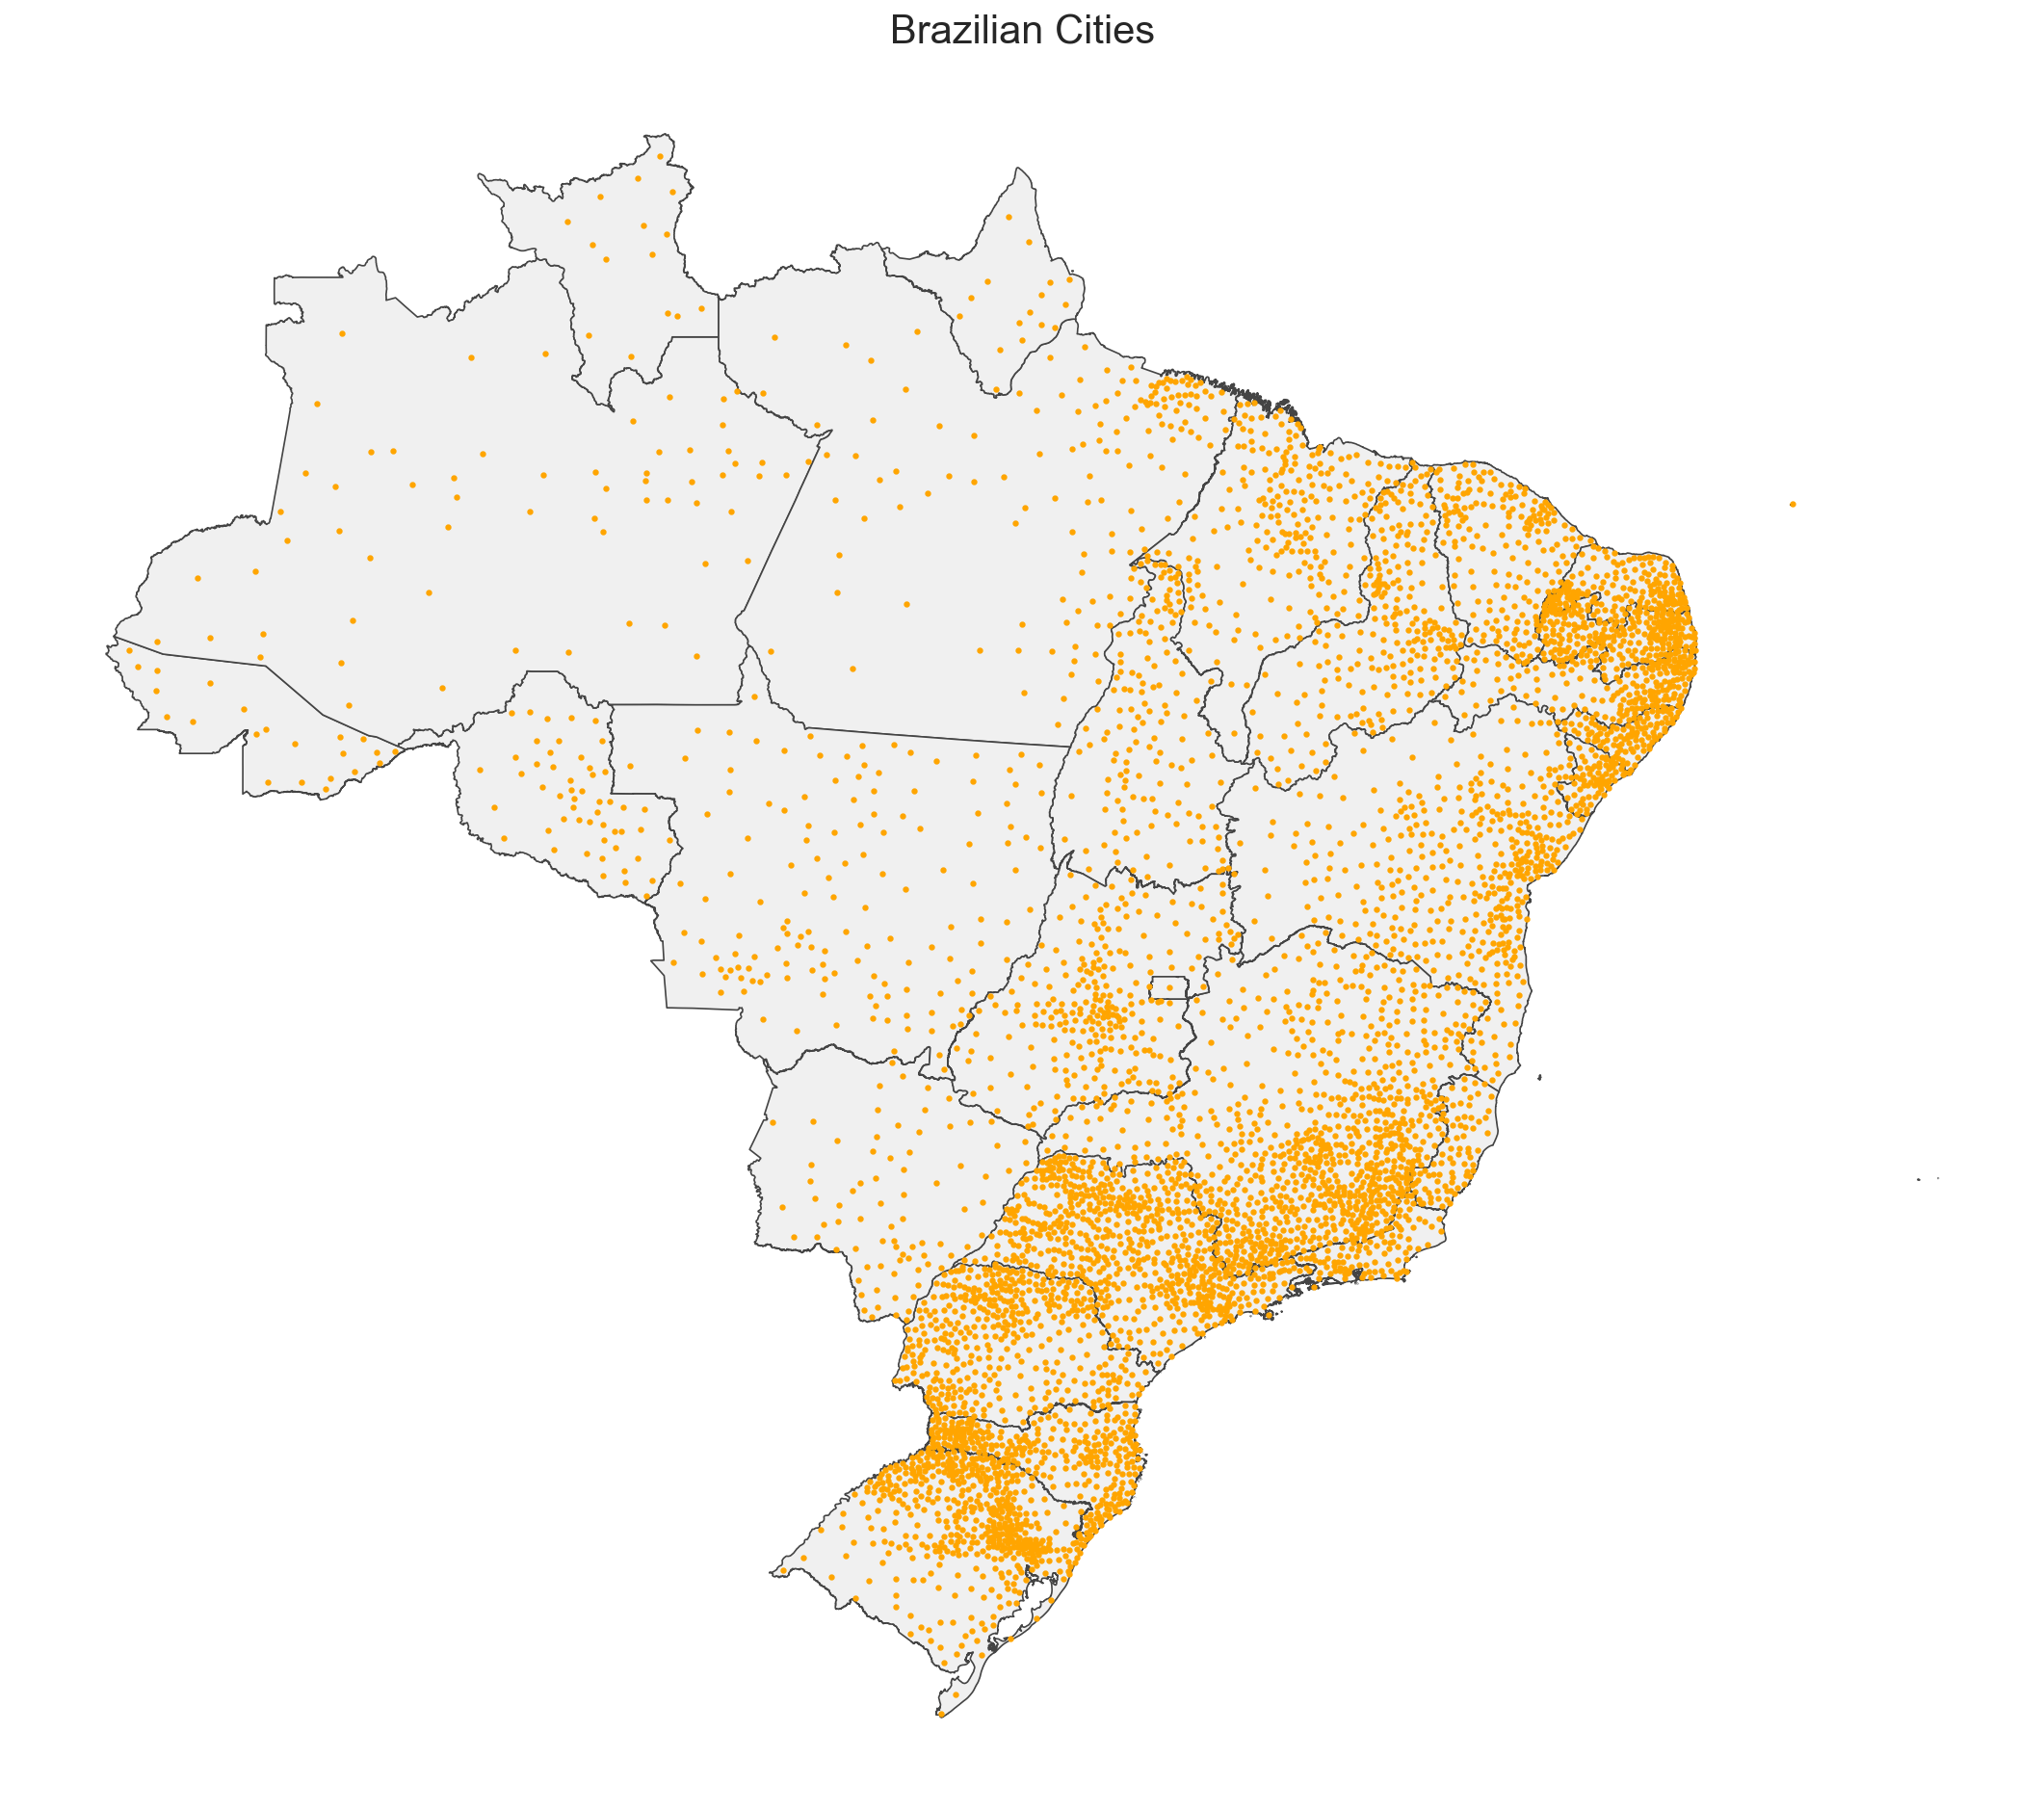

In [57]:
ax = br_shp.plot(figsize=(18, 16), color='#F0F0F0', edgecolor='#444444')
br_cities_pnt.plot(ax=ax, color="orange", markersize=5, label='City')
plt.title("Brazilian Cities", fontsize = 20);
plt.axis('off');

### Grouping State data

In [58]:
br_state = br_cities.groupby('UF', as_index=False).agg({
    'COD. UF': 'first',
    'NOME DO MUNICÍPIO': 'count',
    'POPULAÇÃO ESTIMADA': 'sum',
    'AREA [KMˆ2]': 'sum'
})
br_state.shape

(27, 5)

In [59]:
br_state.rename(columns={'NOME DO MUNICÍPIO':'QTD MUNICÍPIOS'}, inplace=True)
br_state['DENS. DEMOG. [hab/kmˆ2]'] = round(br_state['POPULAÇÃO ESTIMADA'] / br_state['AREA [KMˆ2]'], 2)
br_state['AREA [KMˆ2]'] = round(br_state['AREA [KMˆ2]'], 2)
br_state

UF  COD. UF  QTD MUNICÍPIOS  POPULAÇÃO ESTIMADA  AREA [KMˆ2]  \
0   AC       12              22              881935   168,458.35   
1   AL       27             102             3337357    28,621.12   
2   AM       13              62             4144597  1,571,148.4   
3   AP       16              16              845731   142,618.28   
4   BA       29             417            14873064   592,928.26   
5   CE       23             184             9132078   150,137.08   
6   DF       53               1             3015268     6,217.88   
7   ES       32              78             4018650     51,875.9   
8   GO       52             246             7018354   368,391.83   
9   MA       21             217             7075181   332,594.66   
10  MG       31             853            21168791    652,288.4   
11  MS       50              79             2778986   406,164.05   
12  MT       51             141             3484466   952,334.52   
13  PA       15             144             8602865 1,255,358.39   
14  PB       25             223             4018127    57,345.94   
15  PE       26             185             9557071   100,160.66   
16  PI       22             224             3273227   256,084.83   
17  PR       41             399            11433957    241,027.6   
18  RJ       33              92            17264943    50,989.86   
19  RN       24             167             3506853    53,361.77   
20  RO       11              52             1777225   246,684.97   
21  RR       14              15              605761   224,721.09   
22  RS       43             497            11377239   355,809.53   
23  SC       42             295             7164788    120,972.9   
24  SE       28              75             2298696    22,689.08   
25  SP       35             645            45919049    289,706.7   
26  TO       17             139             1572866   286,897.88   

    DENS. DEMOG. [hab/kmˆ2]  
0                      5.24  
1                     116.6  
2                      2.64  
3                      5.93  
4                     25.08  
5                     60.82  
6                    484.94  
7                     77.47  
8                     19.05  
9                     21.27  
10                    32.45  
11                     6.84  
12                     3.66  
13                     6.85  
14                    70.07  
15                    95.42  
16                    12.78  
17                    47.44  
18                    338.6  
19                    65.72  
20                      7.2  
21                      2.7  
22                    31.98  
23                    59.23  
24                   101.31  
25                    158.5  
26                     5.48

In [60]:
print('Number of Brazilian Cities: {:,}'.format(br_state['QTD MUNICÍPIOS'].sum()))
print('Total Brazilian Population: {:,}'.format(br_state['POPULAÇÃO ESTIMADA'].sum()))
print('Total Brazilian Territory : {:,} km2 (aprox.)'.format(round(br_state['AREA [KMˆ2]'].sum())))

Number of Brazilian Cities: 5,570
Total Brazilian Population: 210,147,125
Total Brazilian Territory : 8,985,590.0 km2 (aprox.)


In [61]:
br_state = pd.merge(br_state, br_shp, on='COD. UF')
br_state= gpd.GeoDataFrame(br_state, crs='4326')
br_state.shape

(27, 10)

In [62]:
br_state.head(2)

UF  COD. UF  QTD MUNICÍPIOS  POPULAÇÃO ESTIMADA  AREA [KMˆ2]  \
0  AC       12              22              881935   168,458.35   
1  AL       27             102             3337357    28,621.12   

   DENS. DEMOG. [hab/kmˆ2]  ID NM_ESTADO NM_REGIAO  \
0                     5.24   2      ACRE     NORTE   
1                    116.6   1   ALAGOAS  NORDESTE   

                                            geometry  
0  POLYGON ((-73.18253 -7.33550, -73.13680 -7.352...  
1  POLYGON ((-35.46753 -8.81744, -35.46659 -8.817...

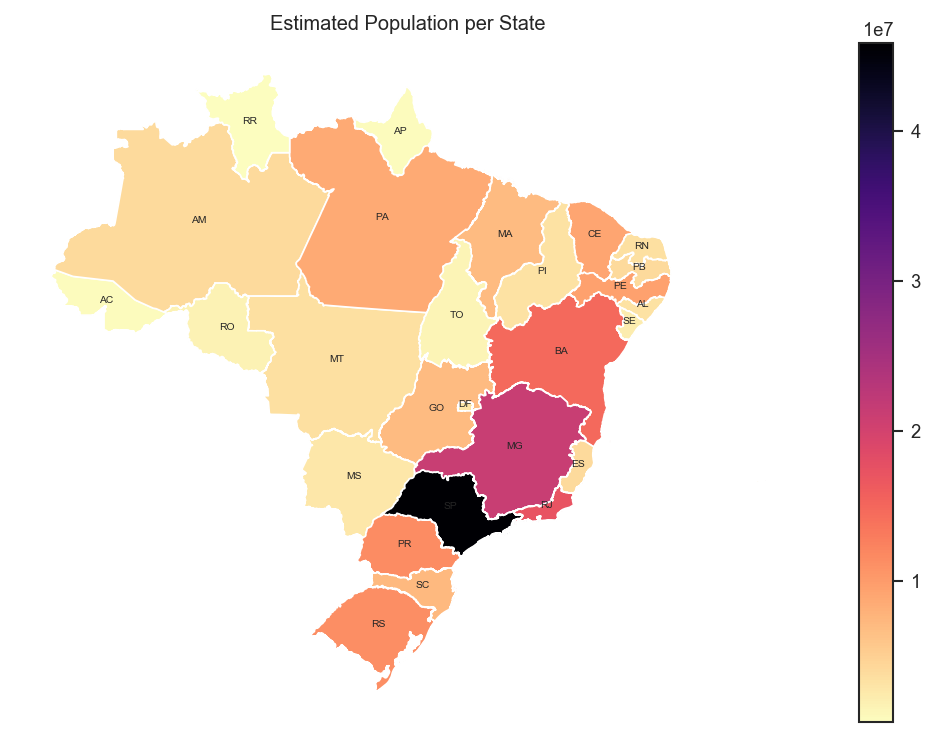

In [63]:
ax = br_state.plot(column='POPULAÇÃO ESTIMADA', cmap='magma_r', legend=True)
plt.title("Estimated Population per State");
ax.set_axis_off()
for idx, row in br_state.iterrows():
    plt.annotate(s=row['UF'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=5);

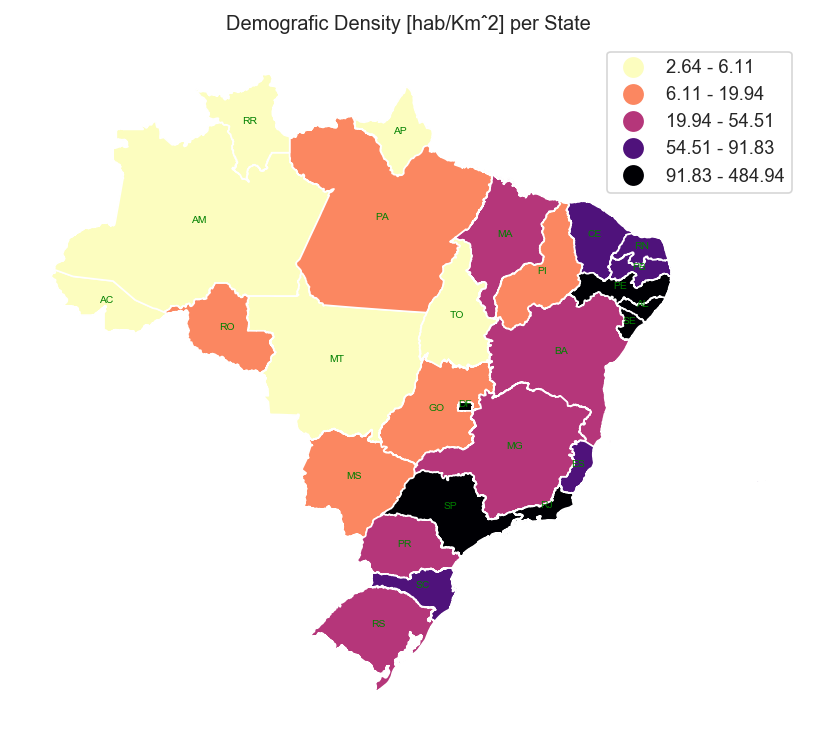

In [64]:
ax = br_state.plot(column='DENS. DEMOG. [hab/kmˆ2]', cmap='magma_r', scheme='quantiles', legend=True)
plt.title("Demografic Density [hab/Kmˆ2] per State");
ax.set_axis_off()
for idx, row in br_state.iterrows():
    plt.annotate(s=row['UF'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=5, color='green');

## Getting POIs

OpenStreetMap data from:
http://download.geofabrik.de/south-america/brazil.html

In [24]:
!ls ../OSM

brazil-140101-free       nordeste-latest-free     sudeste-latest-free
centro-oeste-latest-free norte-latest-free        sul-latest-free


**SouthEast Roads**

In [146]:
!ls ../OSM/sudeste-latest-free

README                         gis_osm_pois_free_1.cpg
gis_osm_buildings_a_free_1.cpg gis_osm_pois_free_1.dbf
gis_osm_buildings_a_free_1.dbf gis_osm_pois_free_1.prj
gis_osm_buildings_a_free_1.prj gis_osm_pois_free_1.shp
gis_osm_buildings_a_free_1.shp gis_osm_pois_free_1.shx
gis_osm_buildings_a_free_1.shx gis_osm_railways_free_1.cpg
gis_osm_landuse_a_free_1.cpg   gis_osm_railways_free_1.dbf
gis_osm_landuse_a_free_1.dbf   gis_osm_railways_free_1.prj
gis_osm_landuse_a_free_1.prj   gis_osm_railways_free_1.shp
gis_osm_landuse_a_free_1.shp   gis_osm_railways_free_1.shx
gis_osm_landuse_a_free_1.shx   gis_osm_roads_free_1.cpg
gis_osm_natural_a_free_1.cpg   gis_osm_roads_free_1.dbf
gis_osm_natural_a_free_1.dbf   gis_osm_roads_free_1.prj
gis_osm_natural_a_free_1.prj   gis_osm_roads_free_1.shp
gis_osm_natural_a_free_1.shp   gis_osm_roads_free_1.shx
gis_osm_natural_a_free_1.shx   gis_osm_traffic_a_free_1.cpg
gis_osm_natural_free_1.cpg     gis_osm_traffic_a_free_1.dbf
gis_osm_natural_free_1.dbf    

In [147]:
file = '../OSM/sudeste-latest-free/gis_osm_roads_free_1.shp'

In [148]:
se_roads_shp = gpd.read_file(file, encoding = 'utf-8')
se_roads_shp.shape

(1617775, 11)

In [149]:
se_motorway = se_roads_shp.loc[se_roads_shp.fclass == 'motorway'].copy()
se_motorway.shape

(14223, 11)

In [150]:
se_primary = se_roads_shp.loc[se_roads_shp.fclass == 'primary'].copy()
se_primary.shape

(39251, 11)

In [151]:
# liberating memory
lst = [se_roads_shp]
del se_roads_shp
del lst

In [166]:
se_shp = br_shp.loc[(br_shp['COD. UF'] == 35) | 
                    (br_shp['COD. UF'] == 31) |
                    (br_shp['COD. UF'] == 33) 
                   ].copy()
se_shp = se_shp.to_crs({'init': 'epsg:4326'})

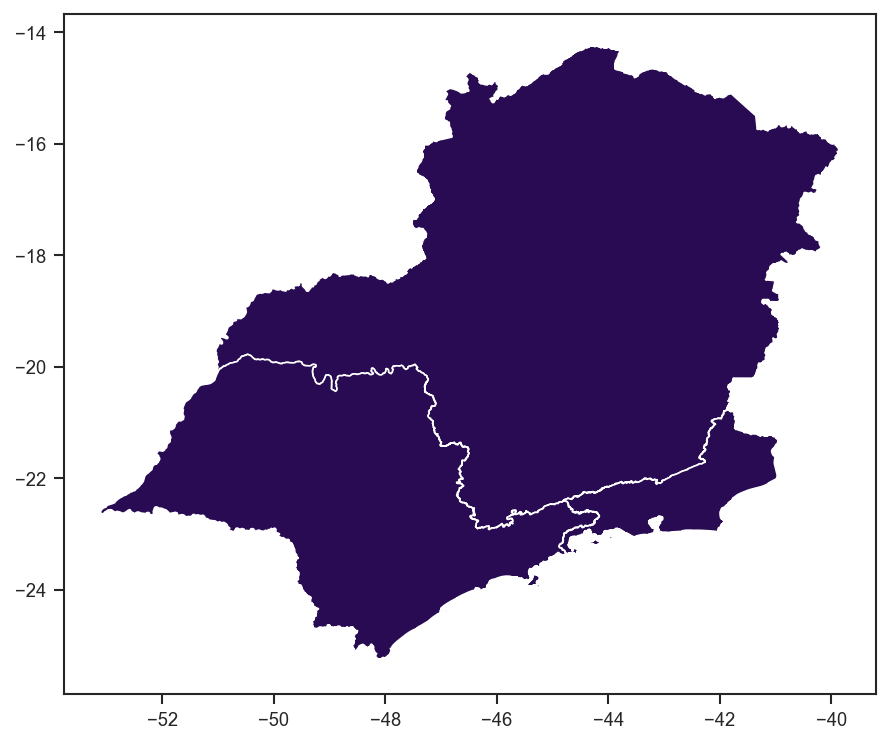

In [167]:
se_shp.plot();

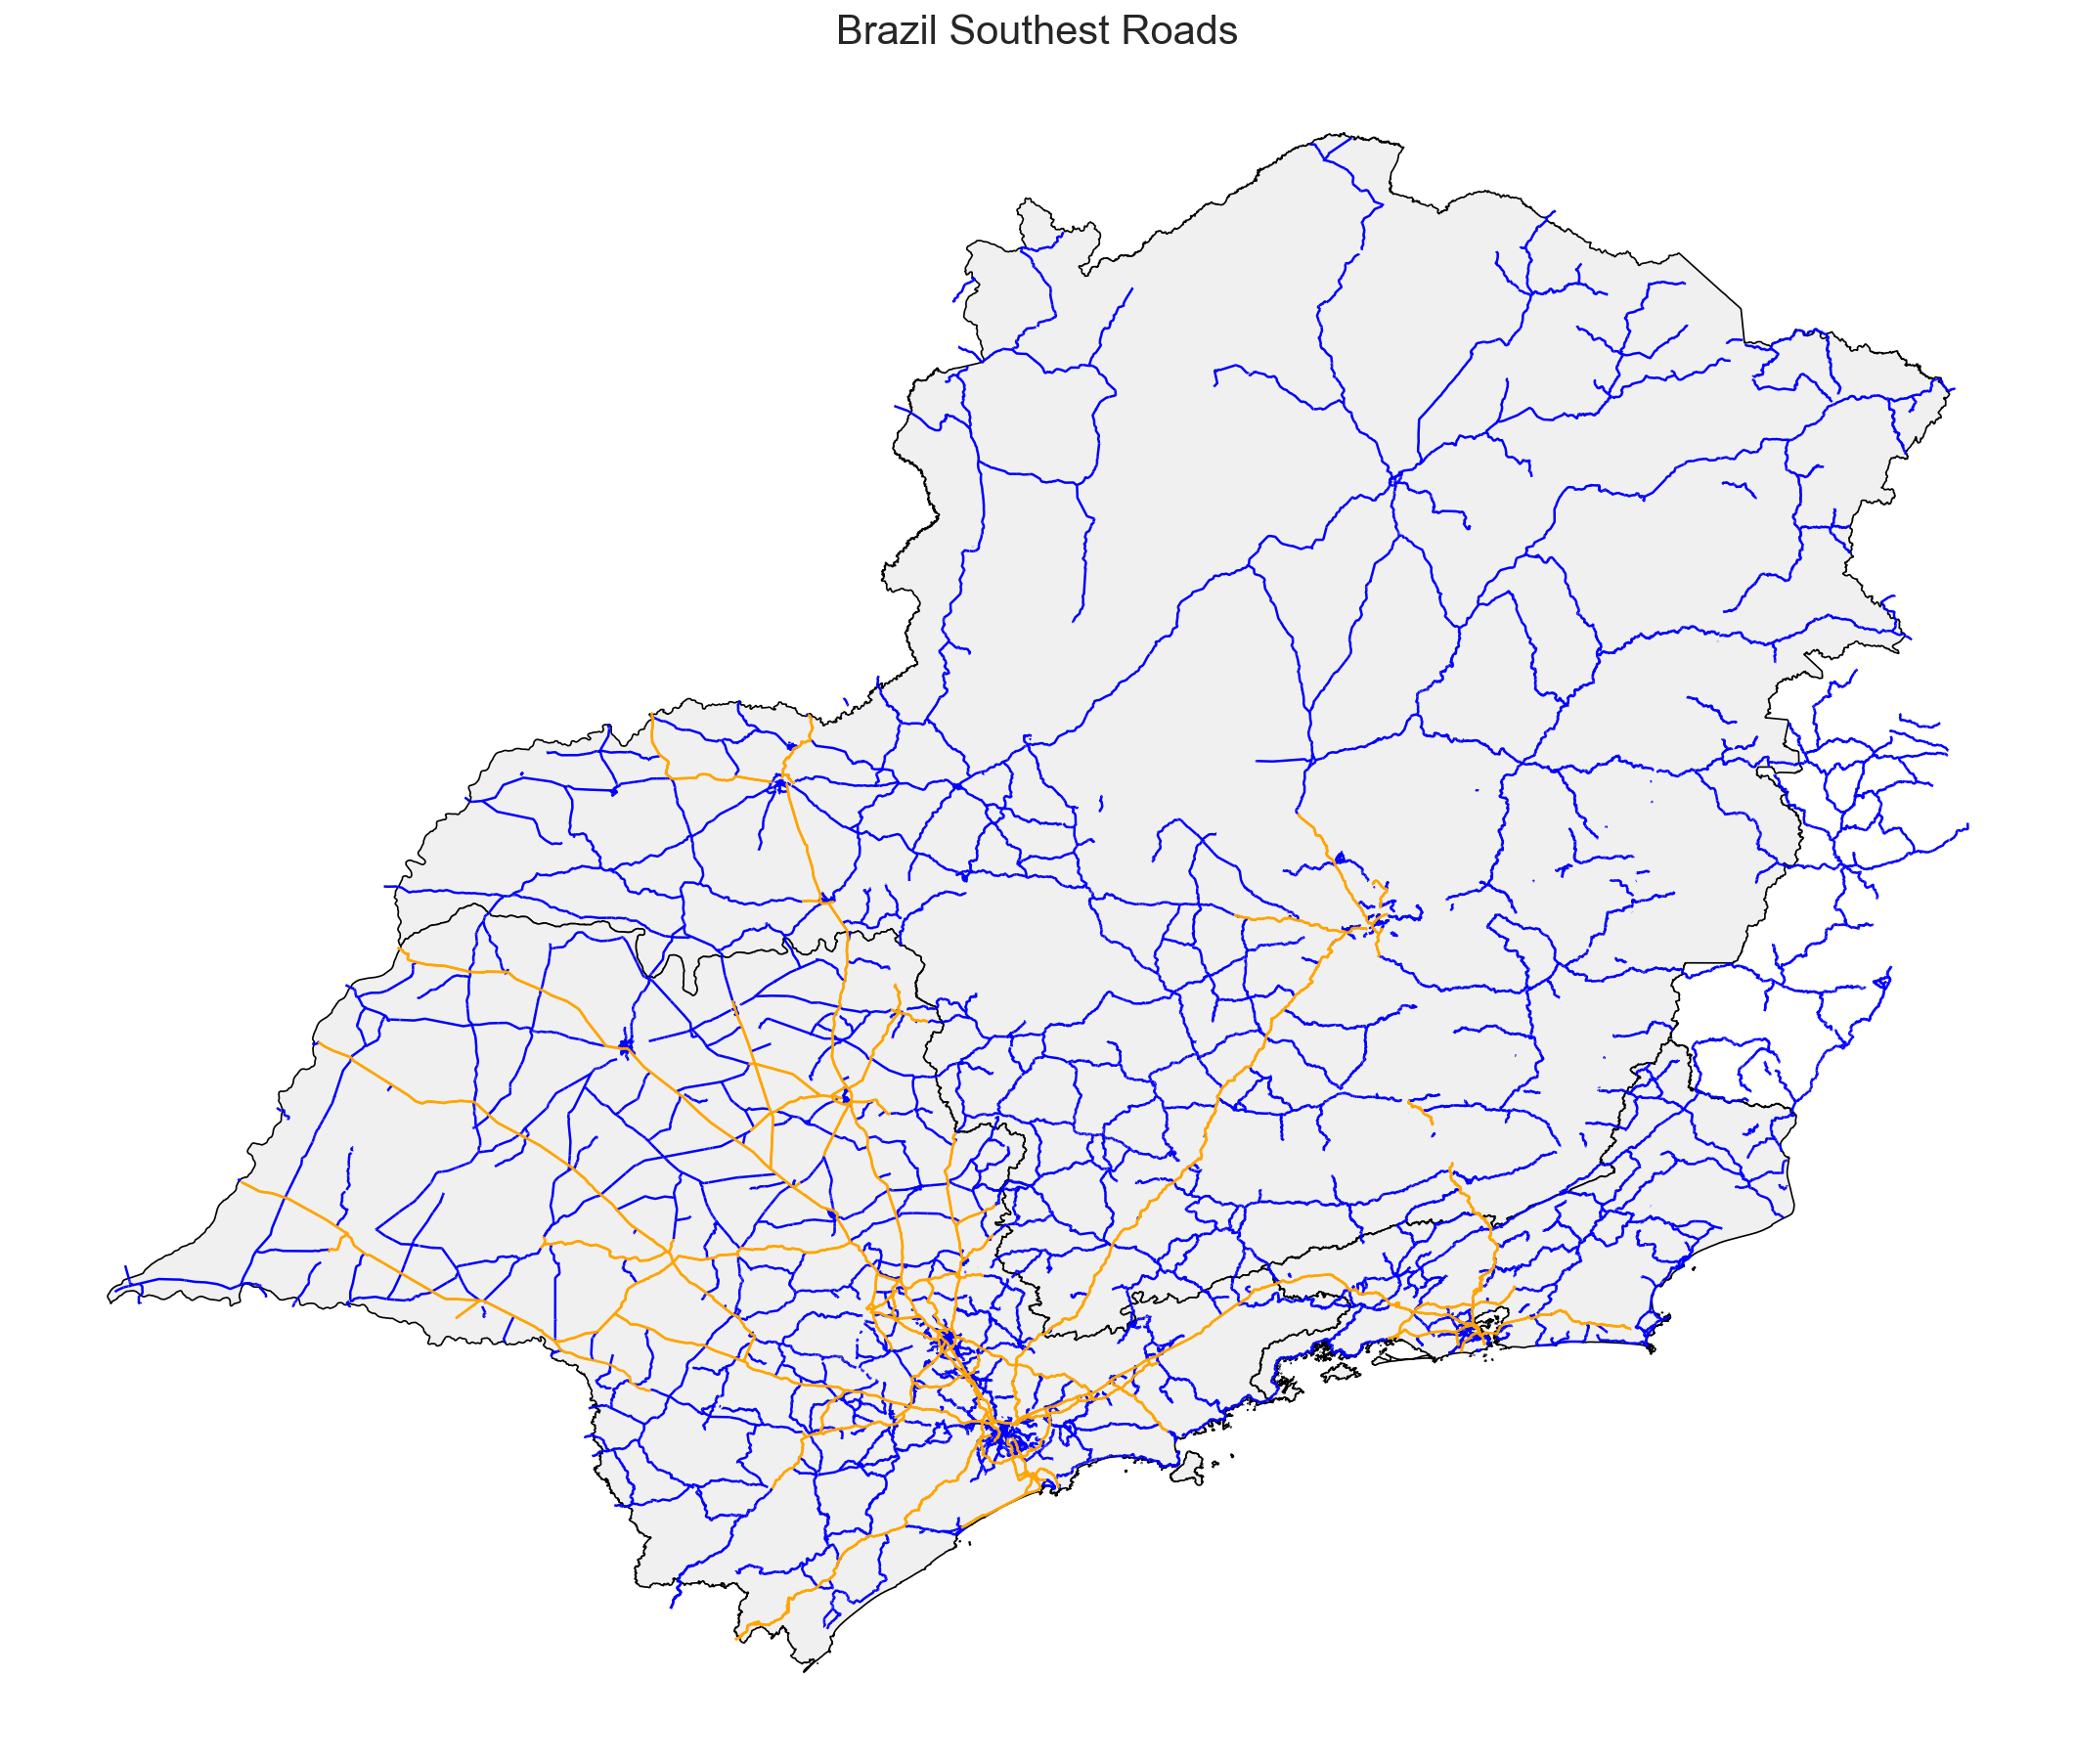

In [168]:
ax = se_shp.plot(figsize=(18, 16), color='#F0F0F0', edgecolor='#000000')
se_primary.plot(ax=ax, color="blue")
se_motorway.plot(ax=ax, color="orange", markersize=5)
plt.title("Brazil Southeast Roads", fontsize = 20);
plt.axis('off');

**NorthEast Roads**

In [495]:
file = '../OSM/nordeste-latest-free/gis_osm_roads_free_1.shp'

ne_roads_shp = gpd.read_file(file, encoding = 'utf-8')
ne_roads_shp.shape

(982532, 11)

In [496]:
ne_motorway = ne_roads_shp.loc[ne_roads_shp.fclass == 'motorway'].copy()
ne_motorway.shape

(887, 11)

In [497]:
ne_primary = ne_roads_shp.loc[ne_roads_shp.fclass == 'primary'].copy()
ne_primary.shape

(22835, 11)

In [498]:
# liberating memory
lst = [ne_roads_shp]
del ne_roads_shp
del lst

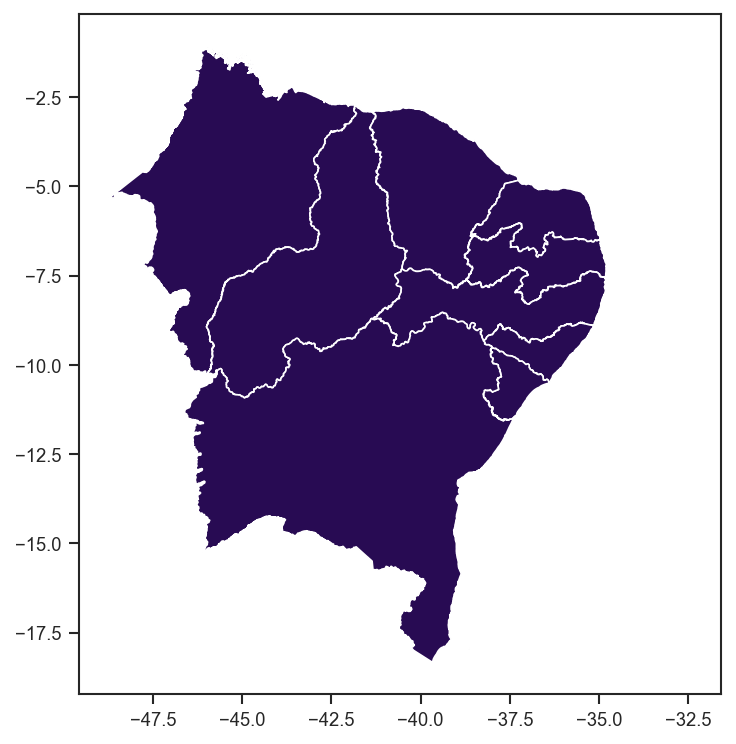

In [499]:
ne_shp = br_shp.loc[(br_shp['NM_REGIAO'] == 'NORDESTE')].copy()
ne_shp = ne_shp.to_crs({'init': 'epsg:4326'})

ne_shp.plot();

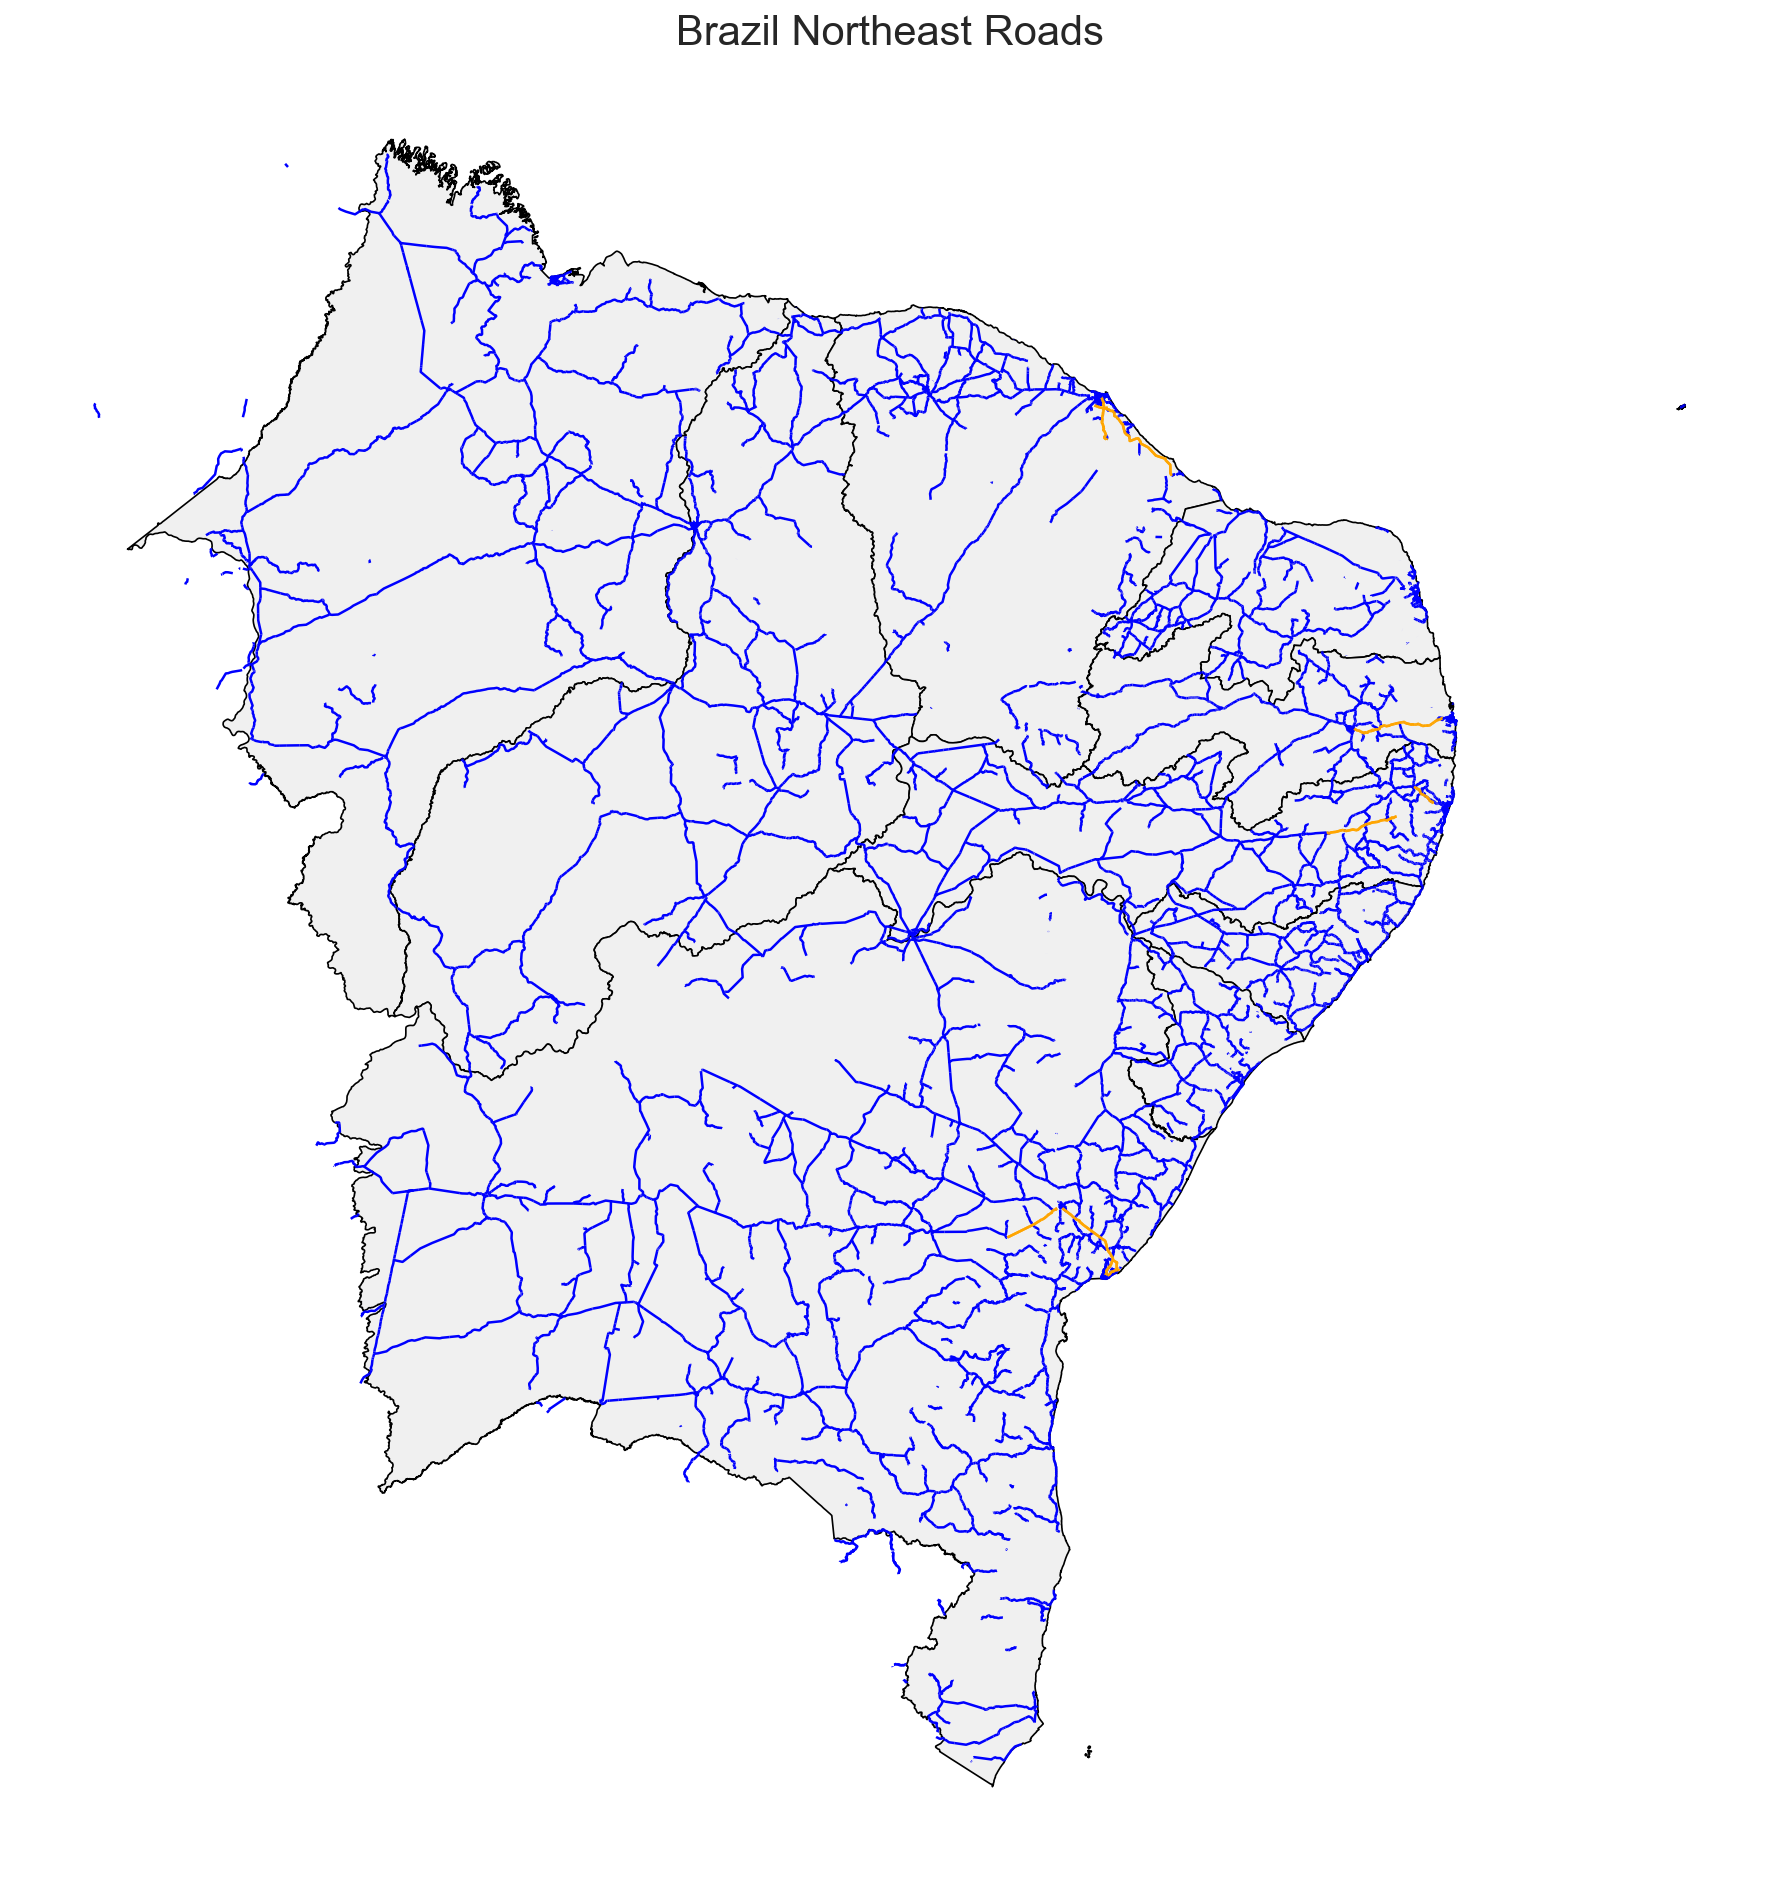

In [500]:
ax = ne_shp.plot(figsize=(18, 16), color='#F0F0F0', edgecolor='#000000')
ne_primary.plot(ax=ax, color="blue")
ne_motorway.plot(ax=ax, color="orange", markersize=5)
plt.title("Brazil Northeast Roads", fontsize = 20);
plt.axis('off');

### Looking Sao Paulo State

In [173]:
sp_shp = se_shp.loc[se_shp['COD. UF'] == 35].copy()
sp_shp = sp_shp.to_crs({'init': 'epsg:4326'})

In [174]:
sp_motorway = gpd.sjoin(se_motorway, sp_shp, op='intersects')

In [175]:
sp_primary = gpd.sjoin(se_primary, sp_shp, op='intersects')

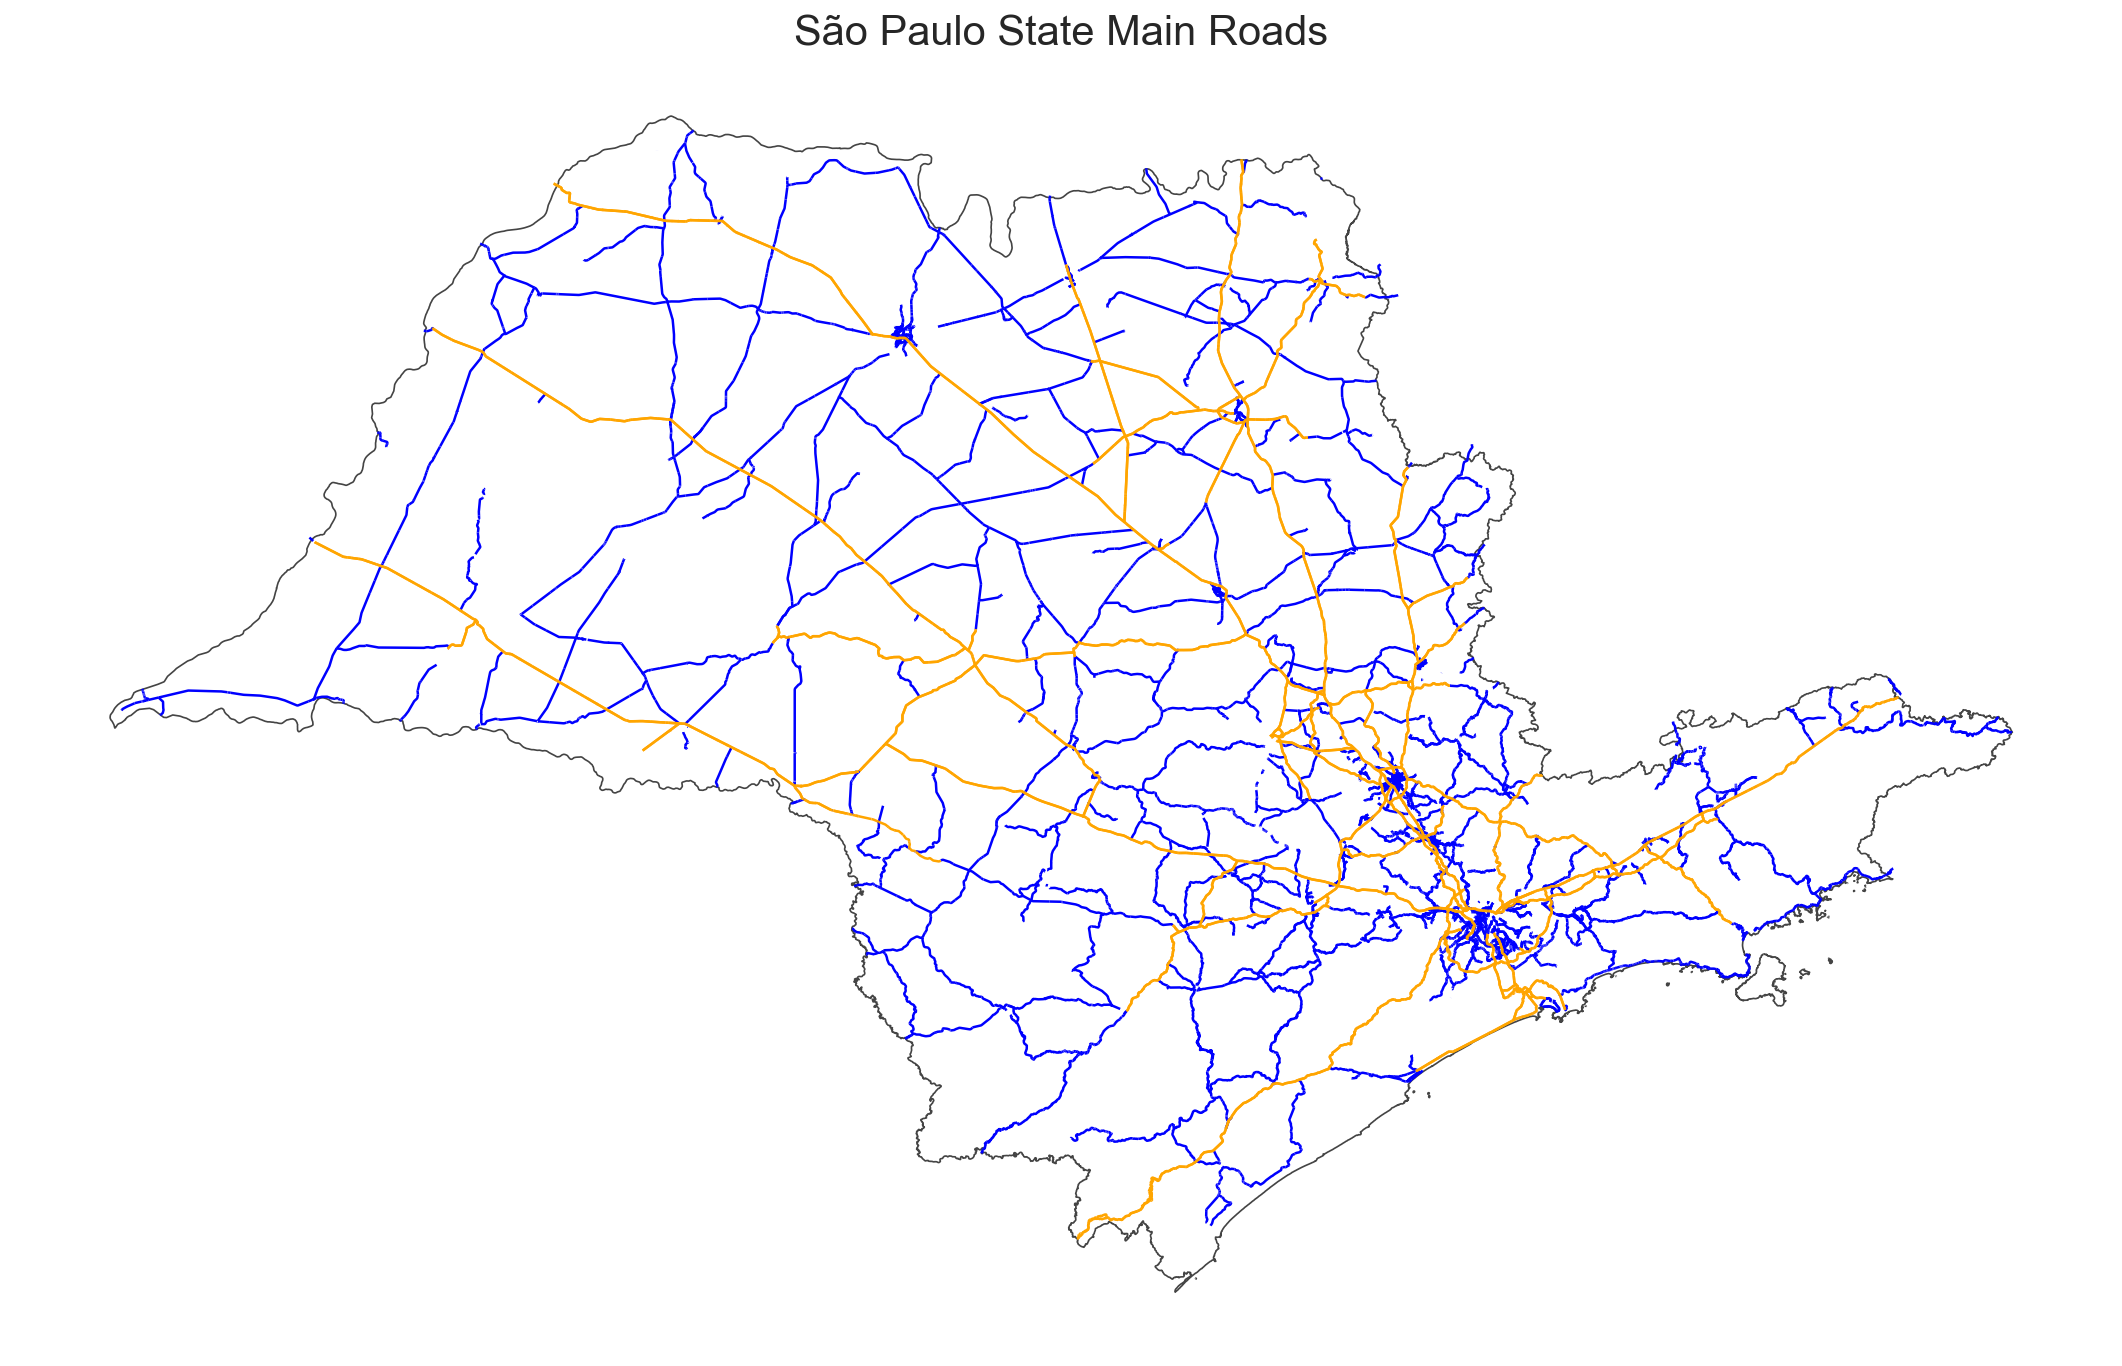

In [176]:
ax = sp_shp.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
sp_primary.plot(ax=ax, color="blue", markersize=1)
sp_motorway.plot(ax=ax, color="orange", markersize=1)
plt.title("São Paulo State Main Roads", fontsize = 20);
plt.axis('off');

### Looking Minas Gerais State

In [177]:
mg_shp = se_shp.loc[se_shp['COD. UF'] == 31].copy()
mg_shp = mg_shp.to_crs({'init': 'epsg:4326'})

In [178]:
mg_motorway = gpd.sjoin(se_motorway, mg_shp, op='intersects')

In [179]:
mg_primary = gpd.sjoin(se_primary, mg_shp, op='intersects')

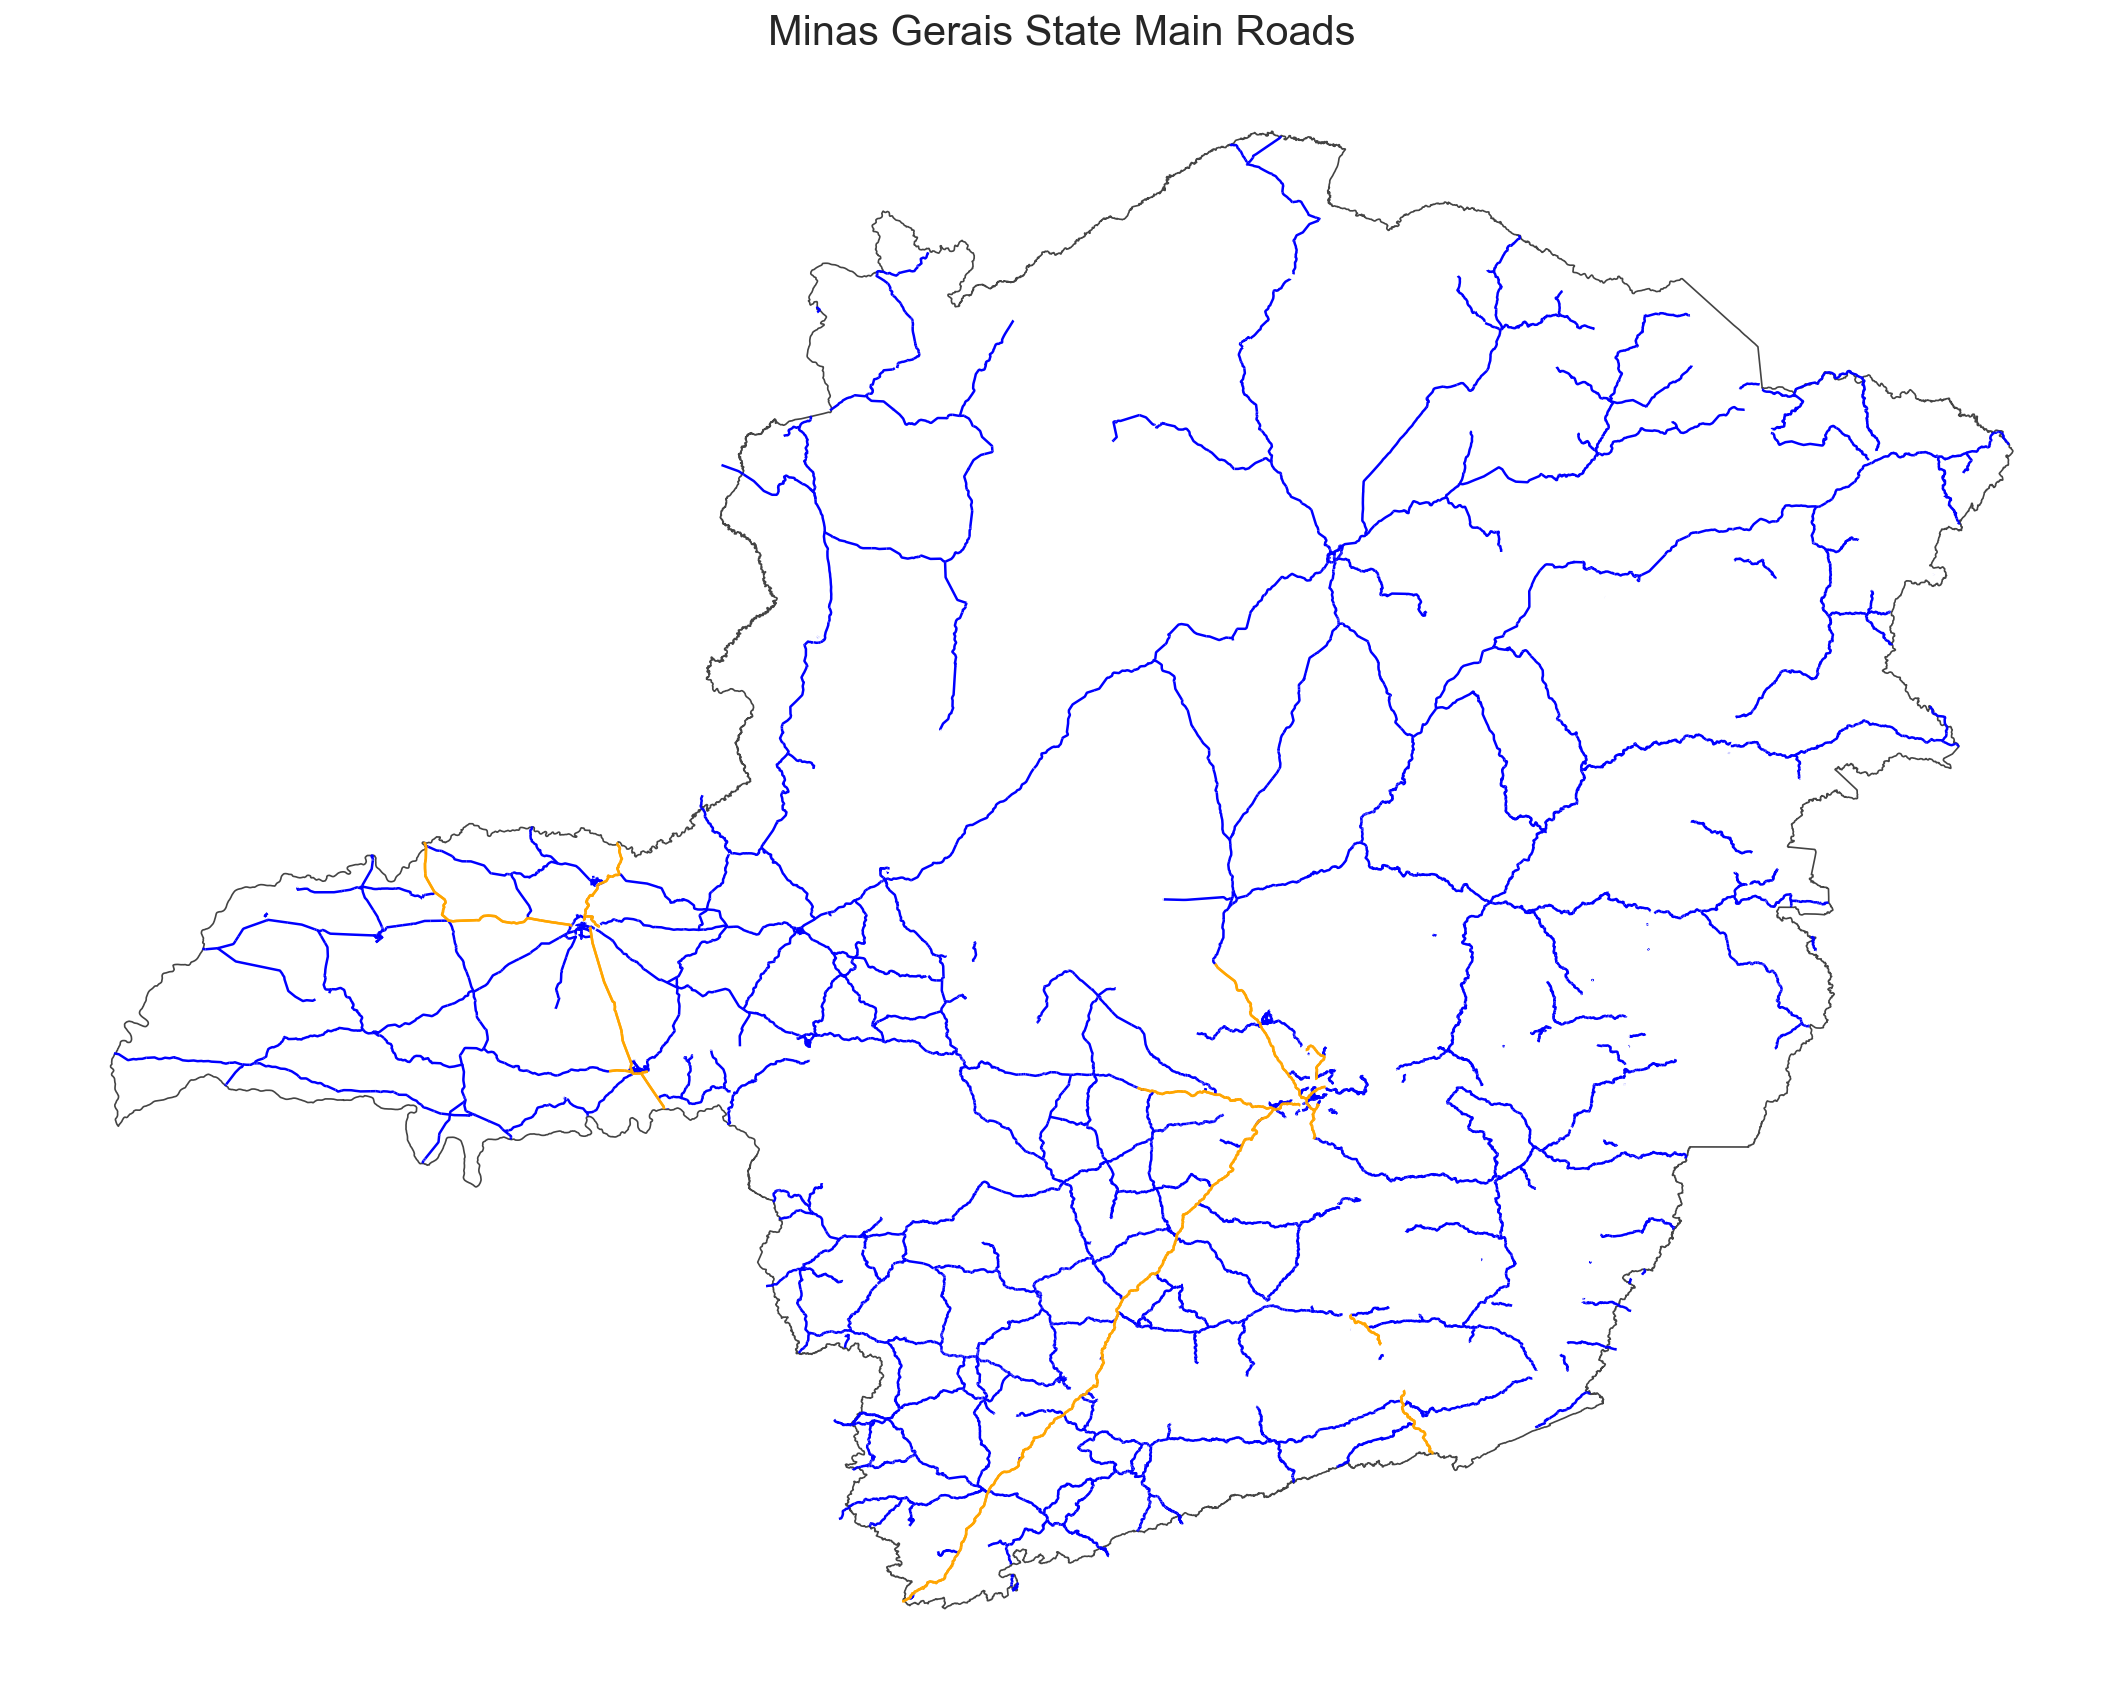

In [180]:
ax = mg_shp.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
mg_primary.plot(ax=ax, color="blue", markersize=1)
mg_motorway.plot(ax=ax, color="orange", markersize=1)
plt.title("Minas Gerais State Main Roads", fontsize = 20);
plt.axis('off');

### Looking Rio de Janeiro State

In [181]:
rj_shp = se_shp.loc[se_shp['COD. UF'] == 33].copy()
rj_shp = rj_shp.to_crs({'init': 'epsg:4326'})

In [182]:
rj_motorway = gpd.sjoin(se_motorway, rj_shp, op='intersects')

In [183]:
rj_primary = gpd.sjoin(se_primary, rj_shp, op='intersects')

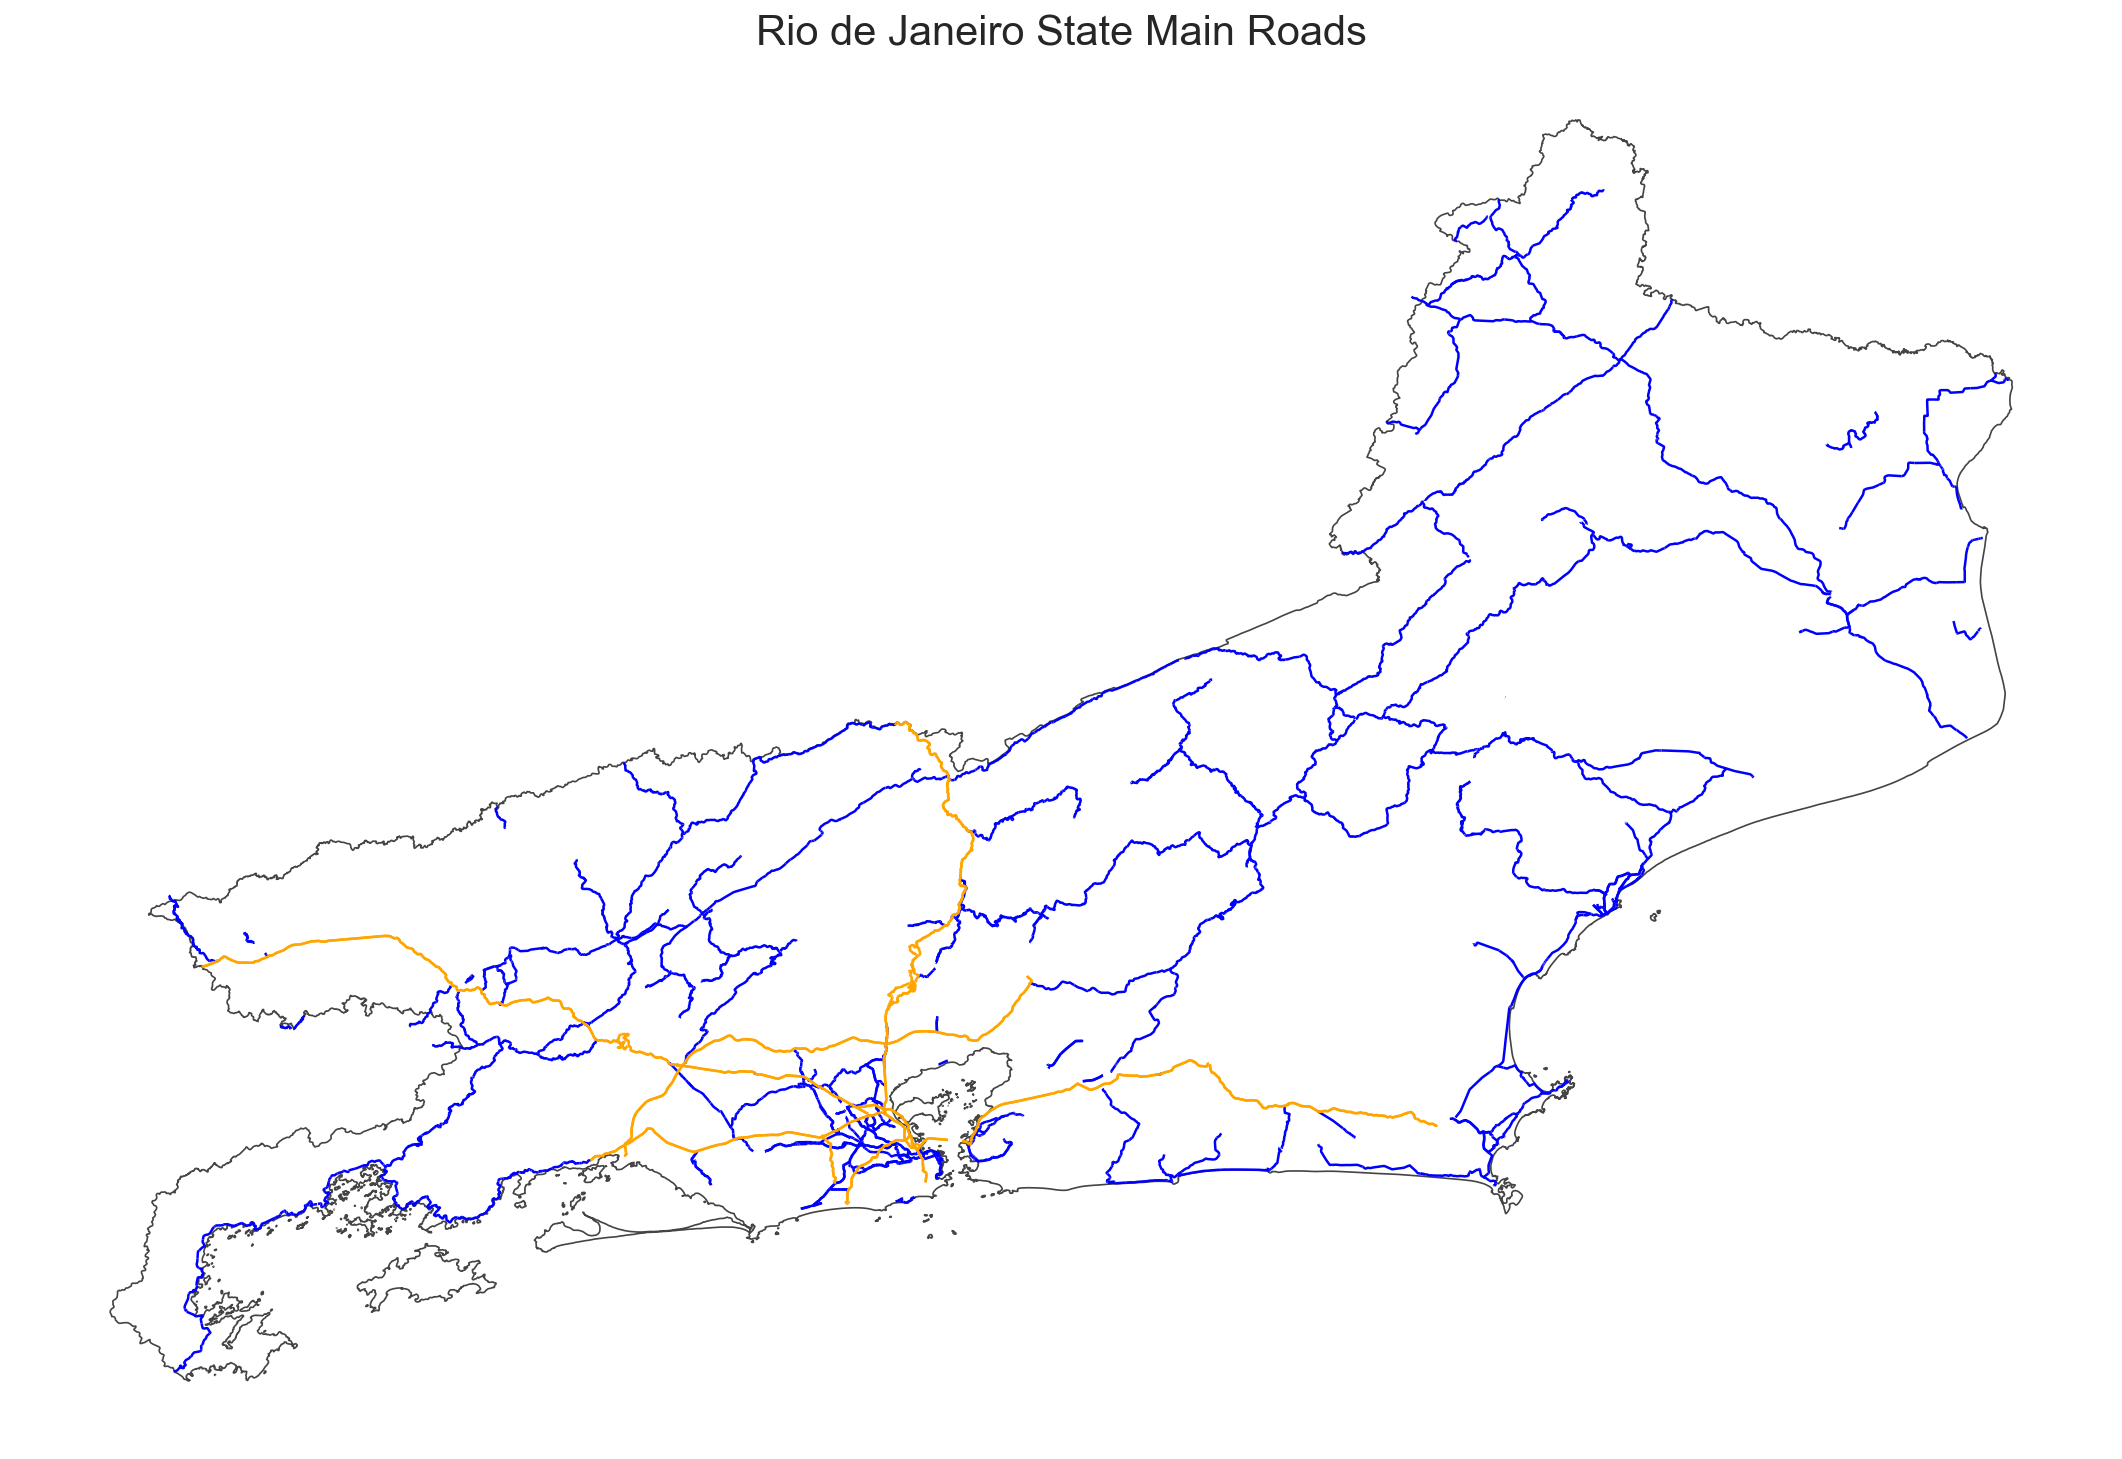

In [184]:
ax = rj_shp.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
rj_primary.plot(ax=ax, color="blue", markersize=1)
rj_motorway.plot(ax=ax, color="orange", markersize=1)
plt.title("Rio de Janeiro State Main Roads", fontsize = 20);
plt.axis('off');

### Looking Ceará State

In [501]:
ce_shp = ne_shp.loc[ne_shp['COD. UF'] == 23].copy()
ce_shp = ce_shp.to_crs({'init': 'epsg:4326'})

In [502]:
ce_motorway = gpd.sjoin(ne_motorway, ce_shp, op='intersects')

In [503]:
ce_primary = gpd.sjoin(ne_primary, ce_shp, op='intersects')

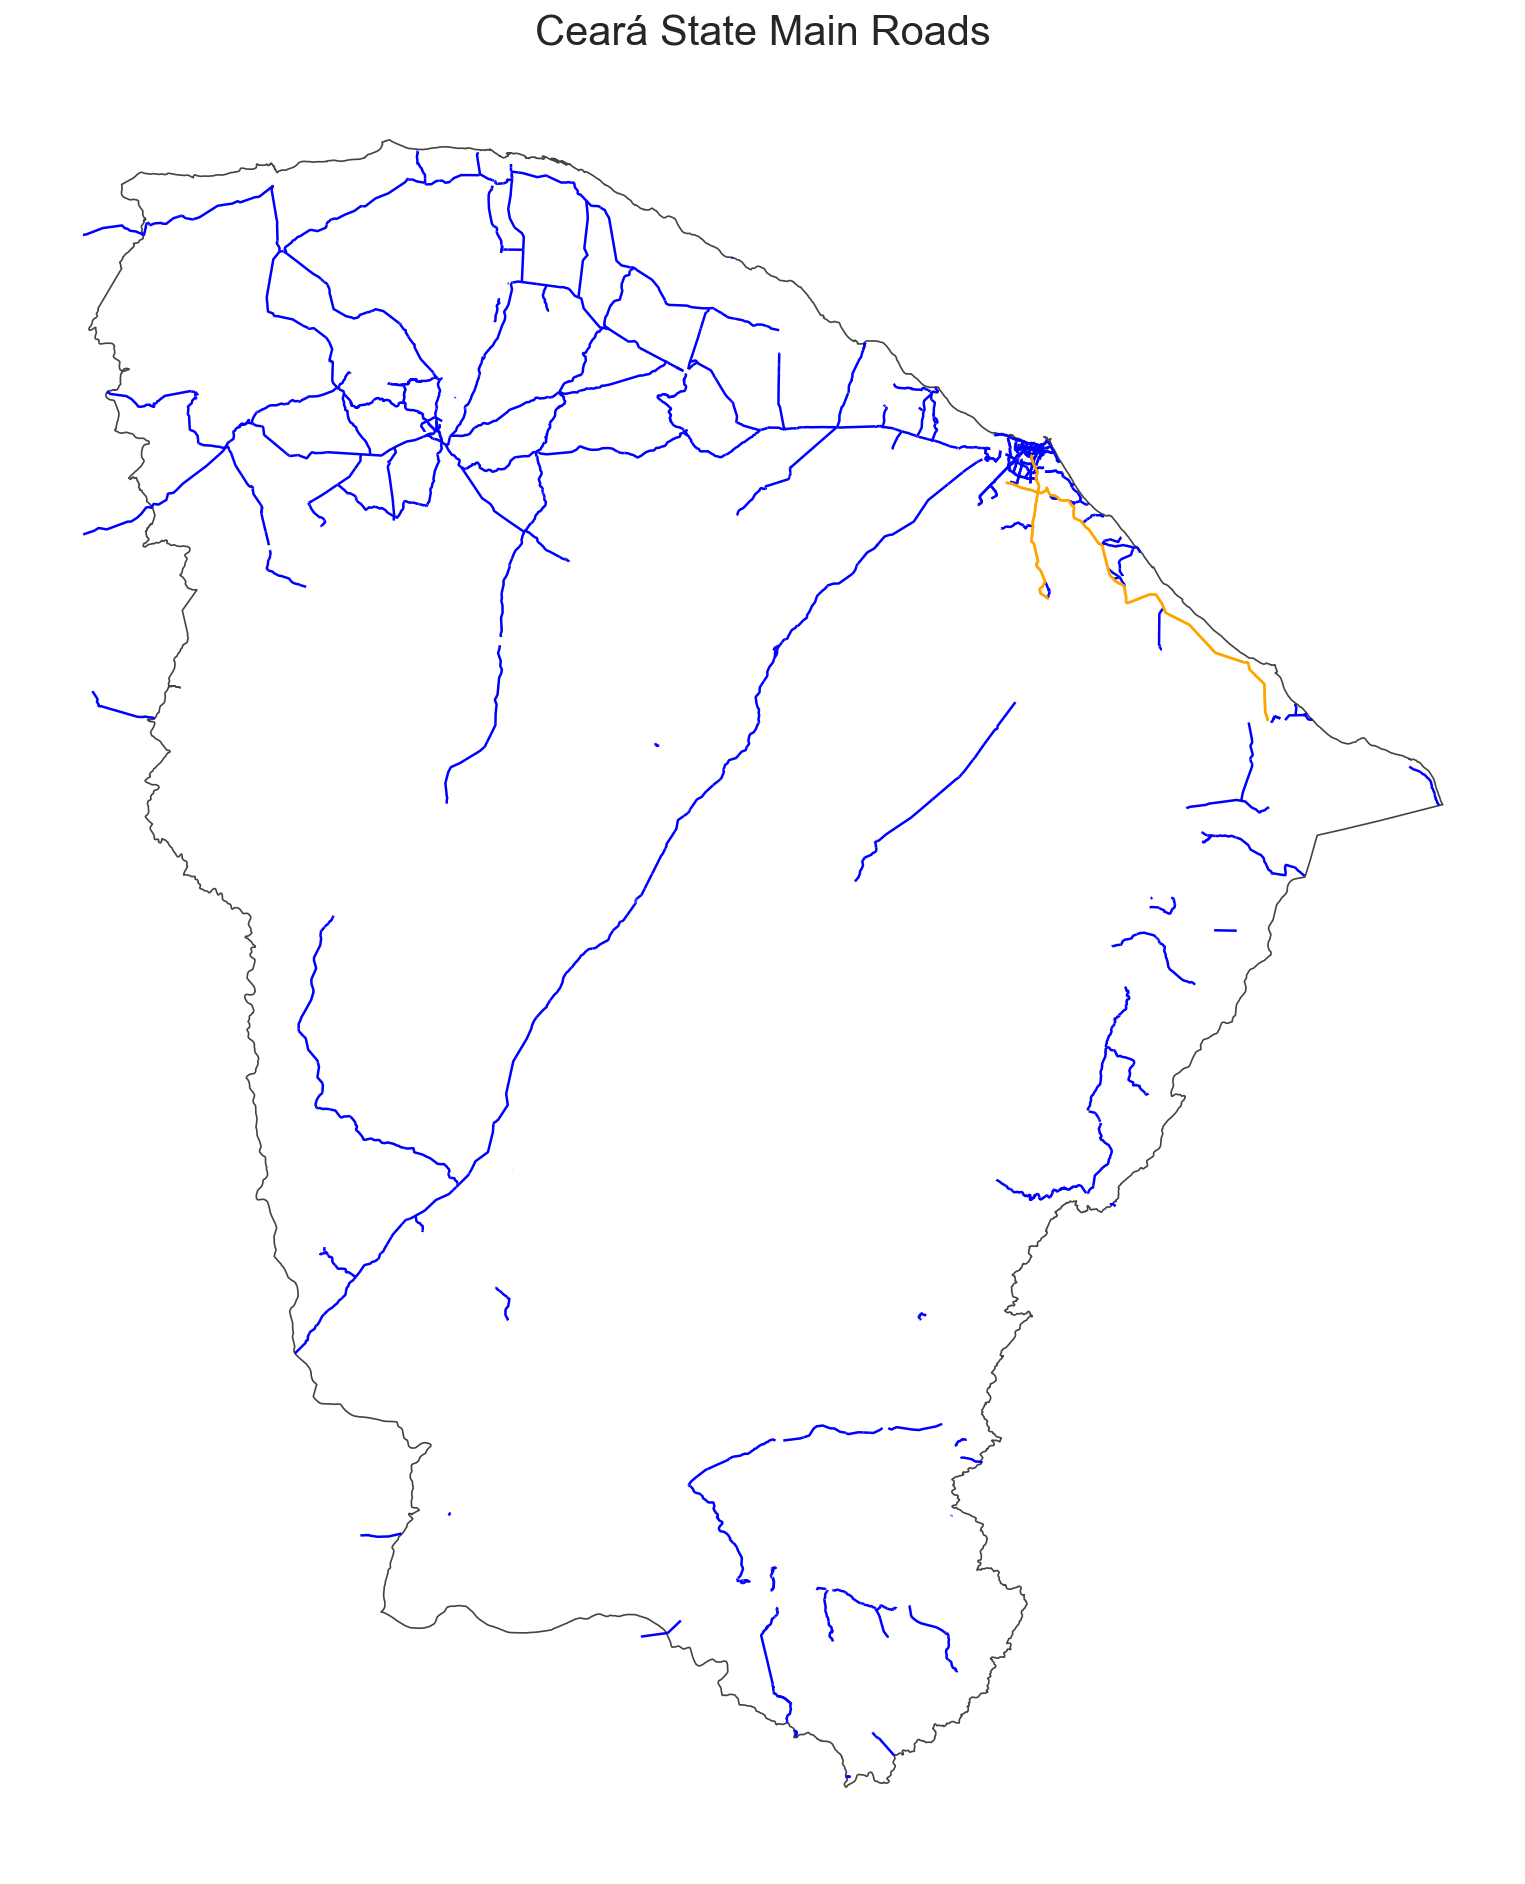

In [504]:
ax = ce_shp.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
ce_primary.plot(ax=ax, color="blue", markersize=1)
ce_motorway.plot(ax=ax, color="orange", markersize=1)
plt.title("Ceará State Main Roads", fontsize = 20);
plt.axis('off');

## Maping CoronaVirus data

### Support Functions

In [437]:
def get_Brazil_data(dt):
    total_cases = dt.totalCases.sum()
    deaths = dt.deaths.sum()
    date = datetime.datetime.today()
    cv_city = pd.merge(dt, br_cities, on='COD. IBGE')
    cv_city = gpd.GeoDataFrame(cv_city, crs='4326')
    deaths_city = cv_city.loc[cv_city['deaths'] != 0].copy()
    cv_city_pnt = cv_city.copy()
    cv_city_pnt['geometry'] = cv_city_pnt['geometry'].representative_point()
    deaths_city_pnt = cv_city_pnt[cv_city_pnt.deaths != 0]
    print('Total number of Covid19 cases reported in Brasil at {}/{}: {:,} ({} fatal) in {} cities'.
        format(date.month, date.day, total_cases, deaths, len(cv_city.index)))
     
    dt_city = cv_city_pnt.sort_values('totalCases', ascending=False).copy()
    dt_city = dt_city[[
    'NOME DO MUNICÍPIO', 'UF', 'POPULAÇÃO ESTIMADA', 'AREA [KMˆ2]',
    'DENS. DEMOG. [hab/kmˆ2]', 'totalCases', 'deaths', 'LATITUDE', 'LONGITUDE']].reset_index(drop=True)
    dt_city.index += 1
    file = '../data_out/cv19_Brazil_'+str(date.month)+'-'+str(date.day)+'-'+str(date.year)+'.xlsx'
    dt_city.to_excel(file)

    return cv_city, deaths_city, cv_city_pnt, deaths_city_pnt, total_cases, deaths

In [574]:
def plt_Brasil_cities(cv_city, deaths_city, date, total_cases, deaths, deaths_only=False):
    ax = br_state.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
    if deaths_only == False:
        cv_city.plot(ax=ax, color="orange", markersize=5, label='City')
    deaths_city.plot(ax=ax,
                     color="red",
                     markersize=5,
                     label='City with Deaths')
    plt.title(
        'Covid19 cases reported in Brasil at {}/{}/{}: {:,} ({} fatal in red) in {} cities'
        .format(date.year, date.month, date.day, total_cases, deaths, len(cv_city.index)),
        fontsize=20, loc='left')
    plt.axis('off')
    
    for idx, row in br_state.iterrows():
        plt.annotate(s=row['UF'],
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center',
                     fontsize=10,
                     color='green')
        
    plt.annotate('(Total numbers including data from not specified cities)',
                 xy=(0.48, .875),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=10)     
        
#     plt.annotate('Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
#         date.year, date.month, date.day),
#                  xy=(-52, -32.9),
#                  fontsize=10,
#                  color='blue')
#     plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
#                  xy=(-52, -33.4),
#                  fontsize=10,
#                  color='blue')
#     plt.annotate(
#         'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/)',
#         xy=(-52, -33.9),
#         fontsize=10,
#         color='blue')

    plt.annotate('Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
        date.year, date.month, date.day),
                 xy=(0.55, .17),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
                 xy=(0.55, .16),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate(
        'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/',
        xy=(0.55, .15),
        xycoords='figure fraction',
        horizontalalignment='left',
        fontsize=12,
        color='blue')
    
    file = '../images/cv19_Brazil_' + str(date.month) + '-' + str(
        date.day) + '-' + str(date.year) + '.png'
        
    file_gif = '../br_images_gif/today_cv19_Brazil.png'

    if deaths_only == False:
        plt.savefig(file, dpi=300)
        plt.savefig(file_gif, dpi=150)

In [573]:
def plt_Brasil_cv_totalcases(cv_city_pnt, deaths_city_pnt, date, total_cases,
                             deaths):
    ax = br_state.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
    cv_city_pnt.plot(ax=ax,
                     color='orange',
                     markersize=4 * cv_city_pnt.totalCases,
                     alpha=.5,
                     label='Covid19 Cases')
    deaths_city_pnt.plot(ax=ax,
                         color='black',
                         marker='+',
                         alpha=.5,
                         markersize=100,
                         label='Deaths')
    plt.title(
        'Covid19 cases reported in Brazil at {}/{}/{}: {:,} ({} fatal) in {} cities'
        .format(date.year, date.month, date.day, total_cases, deaths,
                len(cv_city.index)),
        fontsize=20,
        loc='left')
    plt.axis('off')
    ax.legend(fontsize=15)
    for idx, row in br_state.iterrows():
        plt.annotate(s=row['UF'],
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center',
                     fontsize=10,
                     color='green')

    plt.annotate('(Total numbers including data from not specified cities)',
                 xy=(0.43, .875),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=10)

#     plt.annotate('Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
#         date.year, date.month, date.day),
#                  xy=(-52, -32.9),
#                  fontsize=10,
#                  color='blue')
#     plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
#                  xy=(-52, -33.4),
#                  fontsize=10,
#                  color='blue')
#     plt.annotate(
#         'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/)',
#         xy=(-52, -33.9),
#         fontsize=10,
#         color='blue')

    plt.annotate('Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
        date.year, date.month, date.day),
                 xy=(0.55, .17),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
                 xy=(0.55, .16),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate(
        'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/',
        xy=(0.55, .15),
        xycoords='figure fraction',
        horizontalalignment='left',
        fontsize=12,
        color='blue')

    file = '../images/cv19_Brazil_CV_Total_Cases_' + str(
        date.month) + '-' + str(date.day) + '-' + str(date.year) + '.png'
    plt.savefig(file, dpi=300)

In [509]:
def get_state_info(cv_city, state):
    date = datetime.datetime.today()
    cv_state = cv_city.loc[cv_city['UF'] == state].copy()
    deaths_state = cv_state.loc[cv_state['deaths'] != 0].copy()
    state_total_cases = cv_state.totalCases.sum()
    state_deaths = deaths_state.deaths.sum()
    print(
        'Total number of Covid19 cases reported in {} State at {}/{}: {:,} ({} fatal) in {} specified cities'
        .format(state, date.month, date.day, state_total_cases, state_deaths,
                len(cv_state.index)))
    plot_state_cases(state, cv_state, deaths_state, state_total_cases, state_deaths, date)
    dt_state = cv_state.sort_values('totalCases', ascending=False).copy()
    dt_state = dt_state[[
        'NOME DO MUNICÍPIO', 'UF', 'POPULAÇÃO ESTIMADA', 'AREA [KMˆ2]',
        'DENS. DEMOG. [hab/kmˆ2]', 'totalCases', 'deaths'
    ]].reset_index(drop=True)
    dt_state.index += 1
    file = '../data_out/cv19_'+state+'_'+str(date.month)+'-'+str(date.day)+'-'+str(date.year)+'.xlsx'
    dt_state.to_excel(file)
    return cv_state, deaths_state, state_total_cases, state_deaths

In [582]:
def plot_state_cases(state, cv_state, deaths_state, state_total_cases,
                     state_deaths, date):
    if state == 'SP':
        ax = sp_shp.plot(figsize=(18, 16),
                         color='#FFFFFF',
                         edgecolor='#444444')
        sp_motorway.plot(ax=ax, color="green", markersize=1, label='Motorway')
        sp_primary.plot(ax=ax,
                        color="#E8E8E8",
                        markersize=1,
                        label='Primary Roads')
        xy_1 = (-47.2, -25)
        xy_2 = (-47.2, -25.1)
        xy_3 = (-47.2, -25.2)
    if state == 'RJ':
        ax = rj_shp.plot(figsize=(18, 16),
                         color='#FFFFFF',
                         edgecolor='#444444')
        rj_motorway.plot(ax=ax, color="green", markersize=1, label='Motorway')
        rj_primary.plot(ax=ax,
                        color="#E8E8E8",
                        markersize=1,
                        label='Primary Roads')
        xy_1 = (-42.3, -23.1)
        xy_2 = (-42.3, -23.15)
        xy_3 = (-42.3, -23.2)
    if state == 'MG':
        ax = mg_shp.plot(figsize=(18, 16),
                         color='#FFFFFF',
                         edgecolor='#444444')
        mg_motorway.plot(ax=ax, color="green", markersize=1, label='Motorway')
        mg_primary.plot(ax=ax,
                        color="#E8E8E8",
                        markersize=1,
                        label='Primary Roads')
        xy_1 = (-44.7, -22.8)
        xy_2 = (-44.7, -22.95)
        xy_3 = (-44.7, -23.1)

    if state == 'CE':
        ax = ce_shp.plot(figsize=(18, 16),
                         color='#FFFFFF',
                         edgecolor='#444444')
        ce_motorway.plot(ax=ax, color="green", markersize=1, label='Motorway')
        ce_primary.plot(ax=ax,
                        color="#E8E8E8",
                        markersize=1,
                        label='Primary Roads')
        xy_1 = (-39, -7.95)
        xy_2 = (-39, -8.01)
        xy_3 = (-39, -8.07)

    
        
    cv_state.plot(ax=ax, color="orange", markersize=5, label='City')
    deaths_state.plot(ax=ax,
                      color="red",
                      markersize=5,
                      label='City with Deaths')

    plt.title(
        'Covid19 cases reported in {} State at {}/{}/{}: {:,} ({} fatal in red) in {} specified cities'
        .format(state, date.year, date.month, date.day, state_total_cases, state_deaths,
                len(cv_state.index)),
        fontsize=20, loc='left')
    plt.axis('off')
    ax.legend(fontsize=15)
    
    
    
    plt.annotate(
        'Map created by Marcelo Rovai (MJRoBot.org) @{}/{}/{}'.format(
            date.year, date.month, date.day),
        xy=xy_1,
        fontsize=10,
        color='blue')
    plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
                 xy=xy_2,
                 fontsize=10,
                 color='blue')
    plt.annotate(
        'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/)',
        xy=xy_3,
        fontsize=10,
        color='blue')
    file = '../images/cv19_' + state + '_' + str(date.month) + '-' + str(
        date.day) + '-' + str(date.year) + '.png'
    plt.savefig(file, dpi=300)
    
    file_gif = '../'+state.lower()+'_images_gif/today_cv19_' + state.lower() + '.png'
    plt.savefig(file_gif, dpi=200)

### Nationwide Analysis

In [525]:
cv_city, deaths_city, cv_city_pnt, deaths_city_pnt, total_cases, deaths = get_Brazil_data(dt)

Total number of Covid19 cases reported in Brasil at 4/6: 11,282 (486 fatal) in 606 cities


In [583]:
date = datetime.datetime.today()

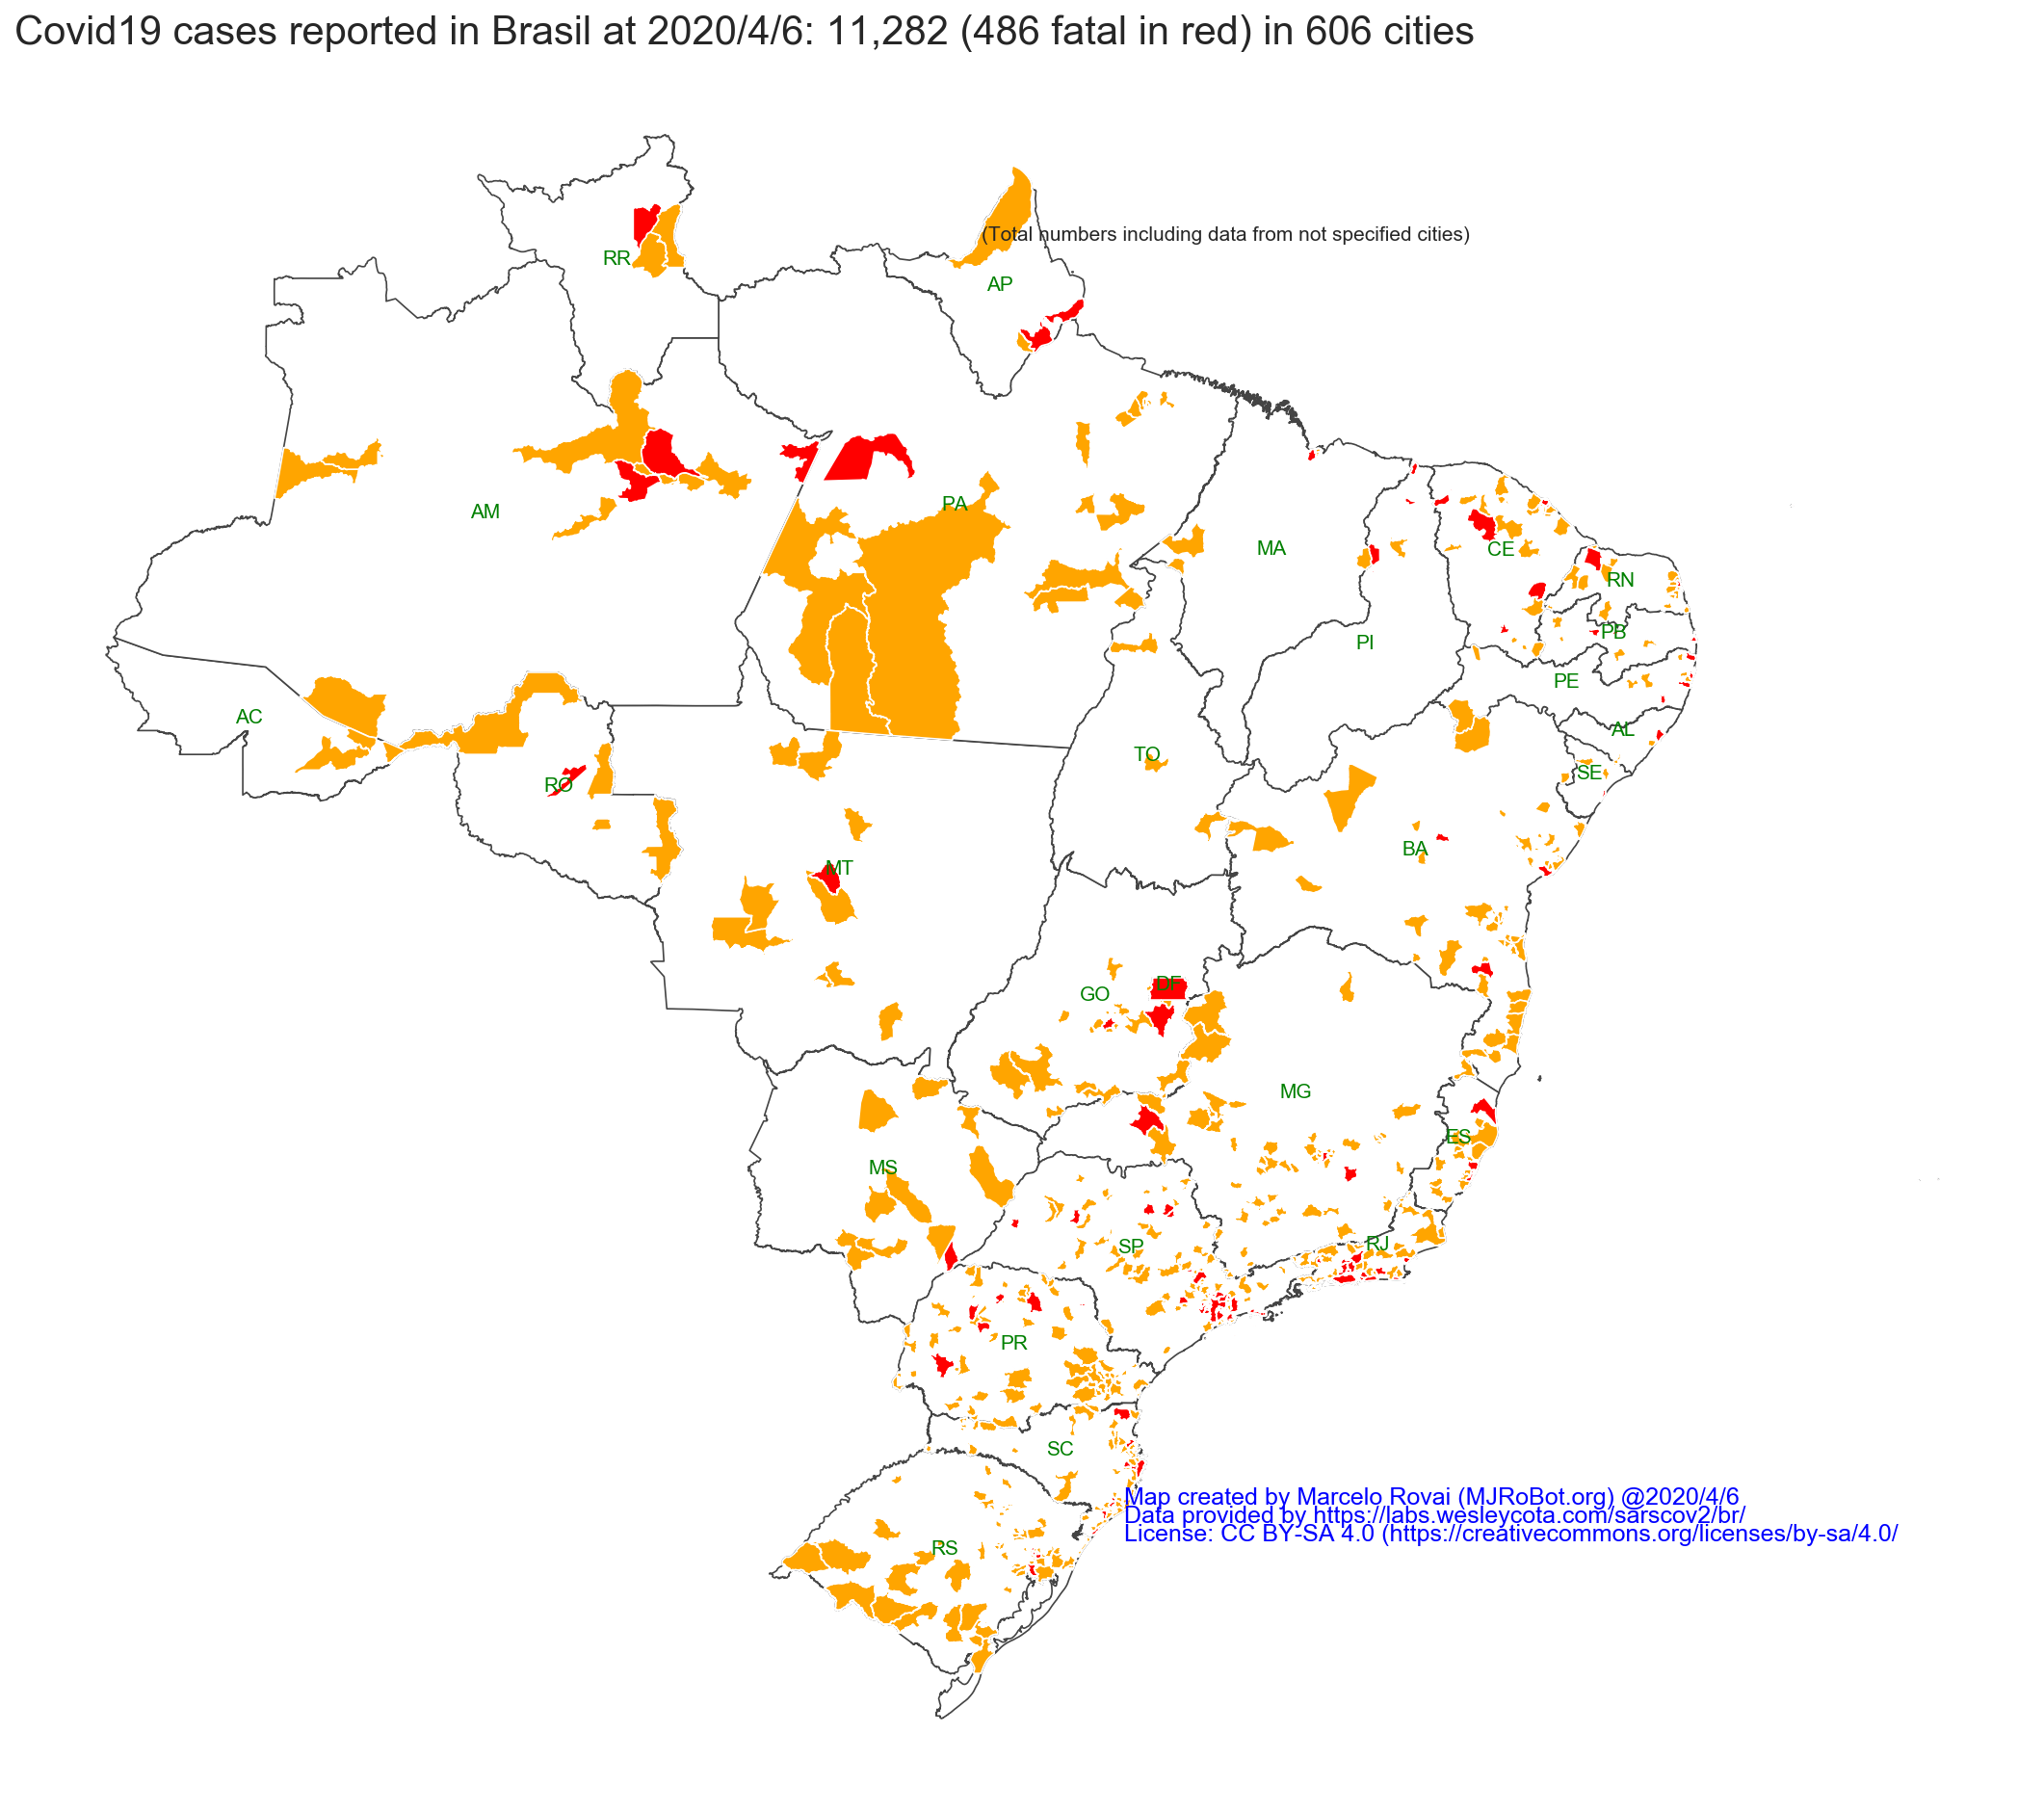

In [576]:
plt_Brasil_cities(cv_city, deaths_city, date, total_cases, deaths, deaths_only=False)

**WARNING** 

Position of annotation in final saved figures is different from the ones showed at Notebook

Saved image example:
<img src="../images/cv19_Brazil_4-6-2020.png">

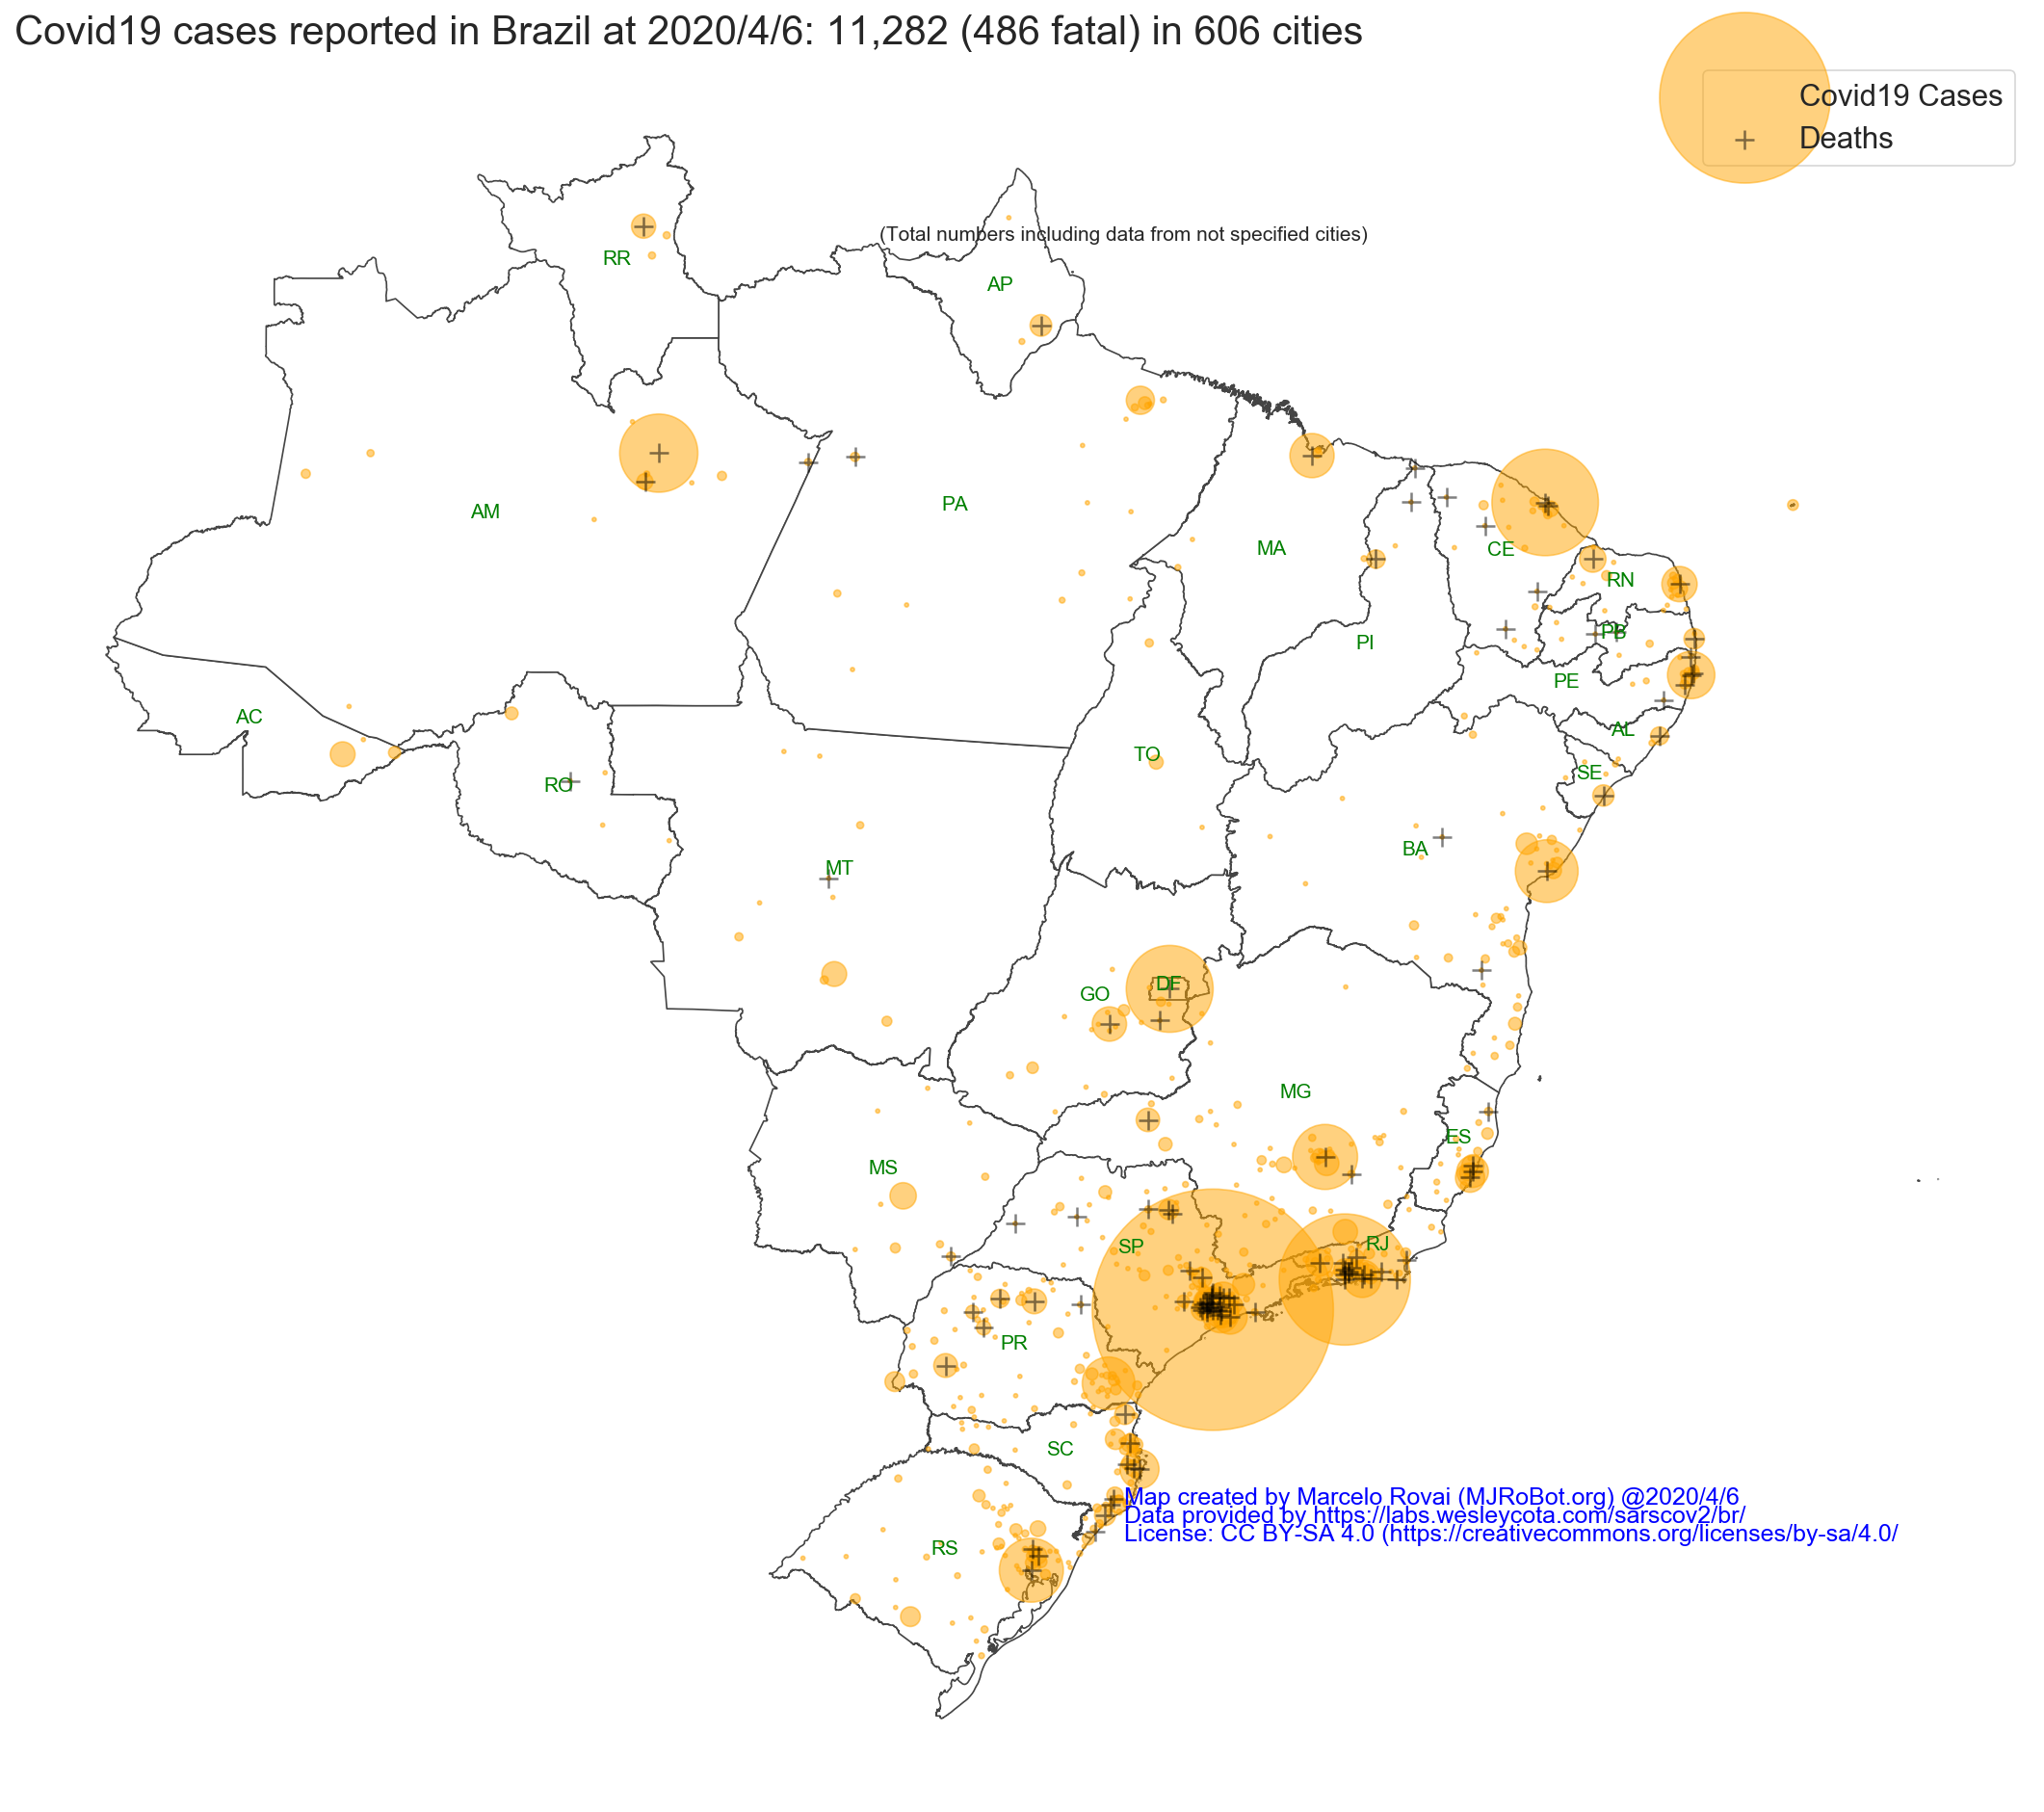

In [577]:
plt_Brasil_cv_totalcases(cv_city_pnt, deaths_city_pnt, date, total_cases, deaths)

### Selected State Analysis

Total number of Covid19 cases reported in SP State at 4/6: 4,547 (259 fatal) in 97 specified cities


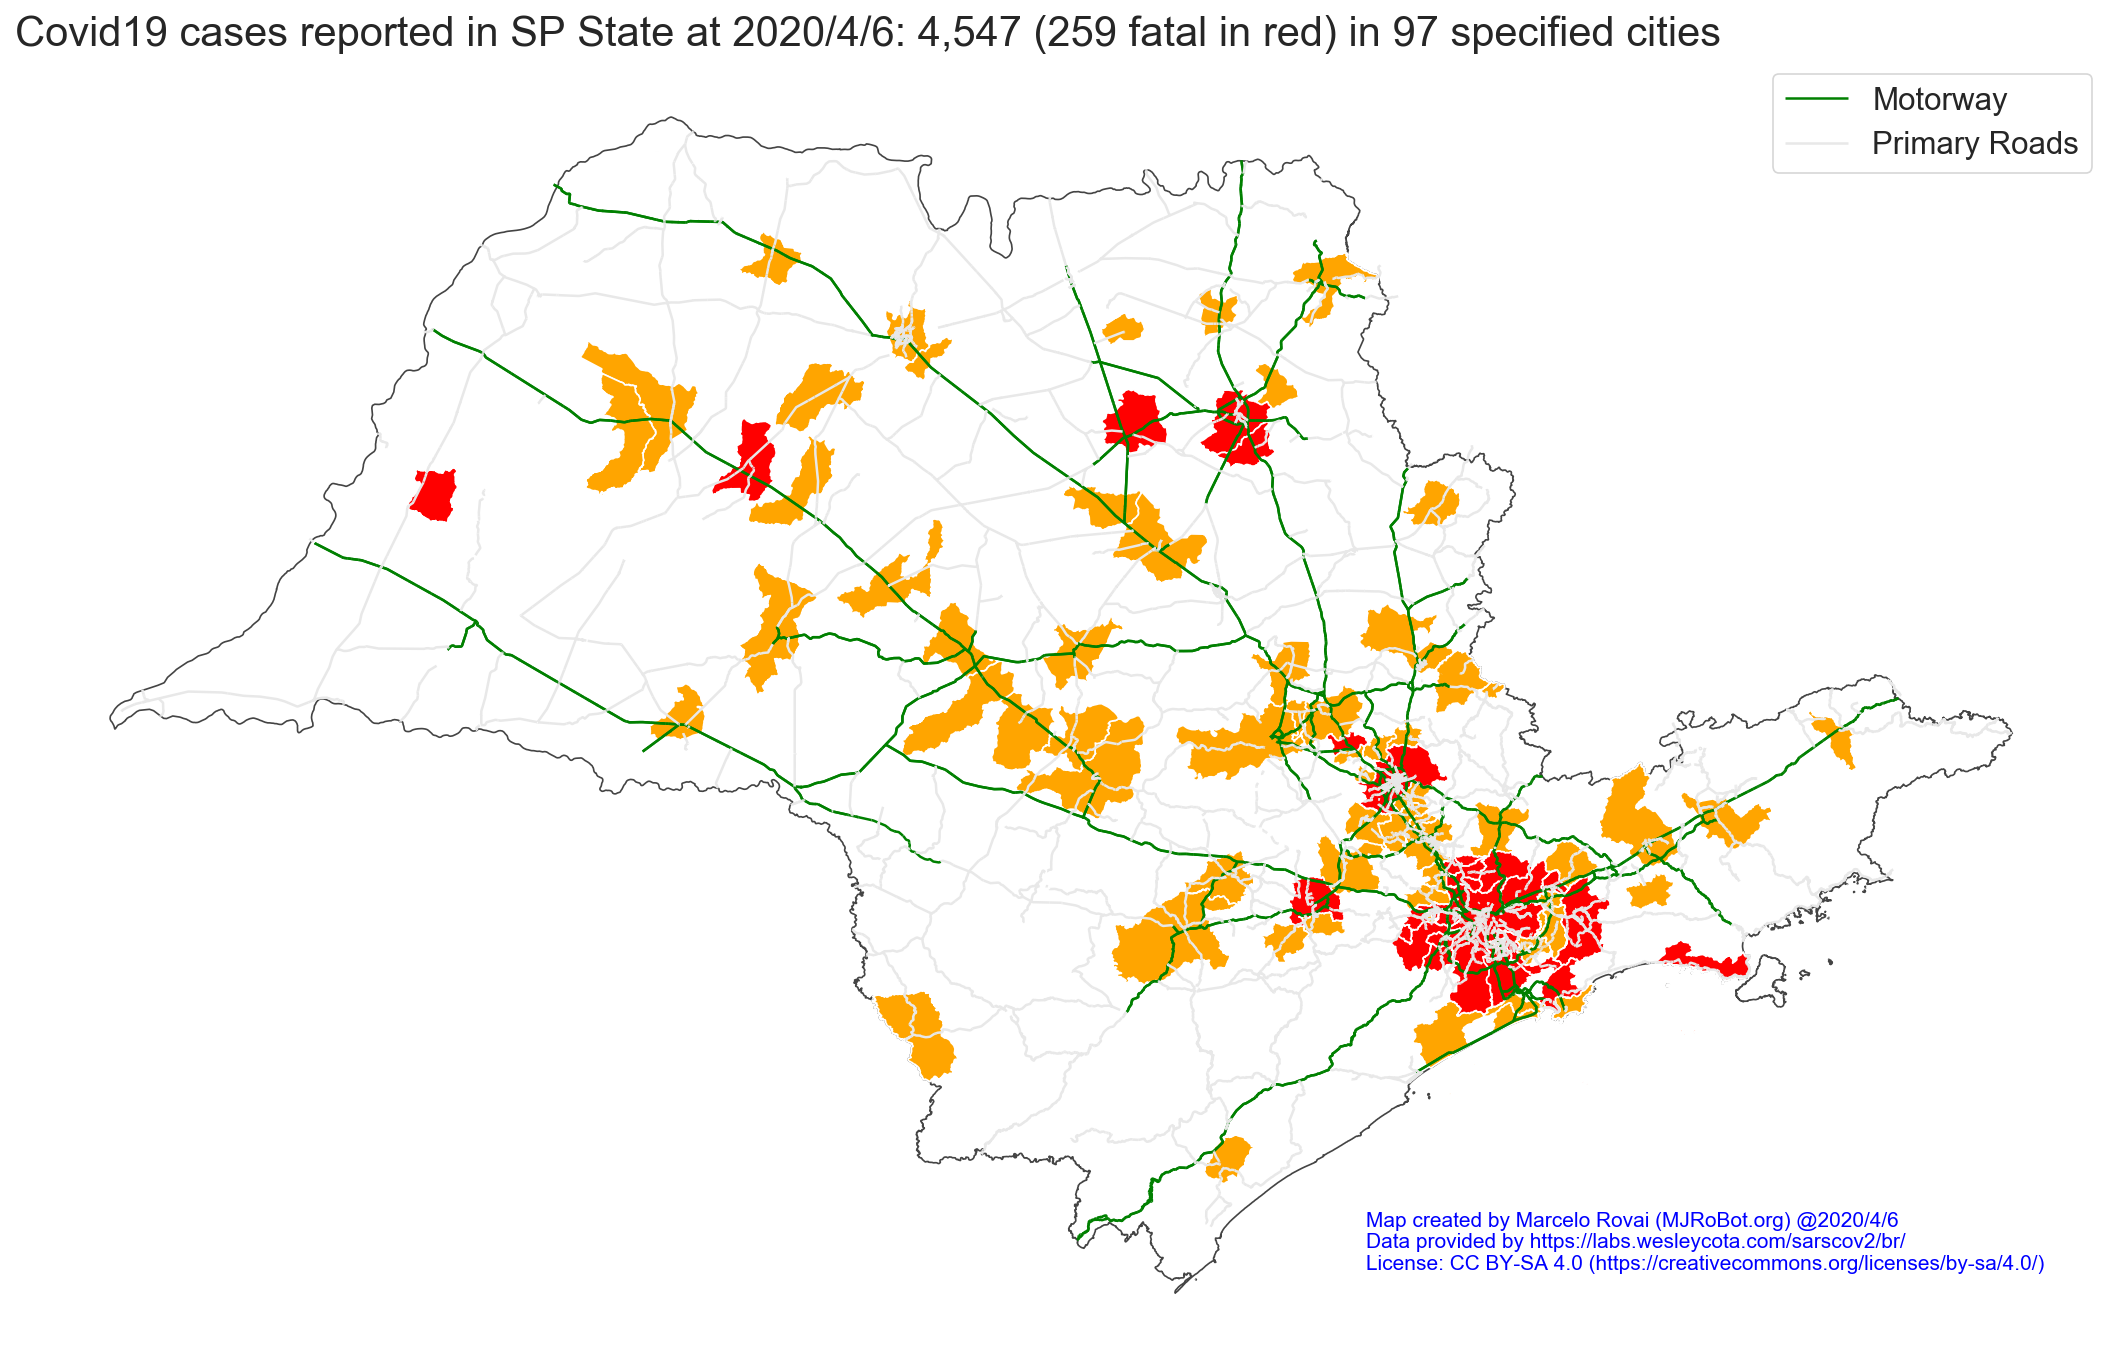

In [584]:
cv_sp, deaths_sp, sp_total_cases, sp_deaths = get_state_info(cv_city, 'SP')

Total number of Covid19 cases reported in RJ State at 4/6: 1,393 (58 fatal) in 42 specified cities


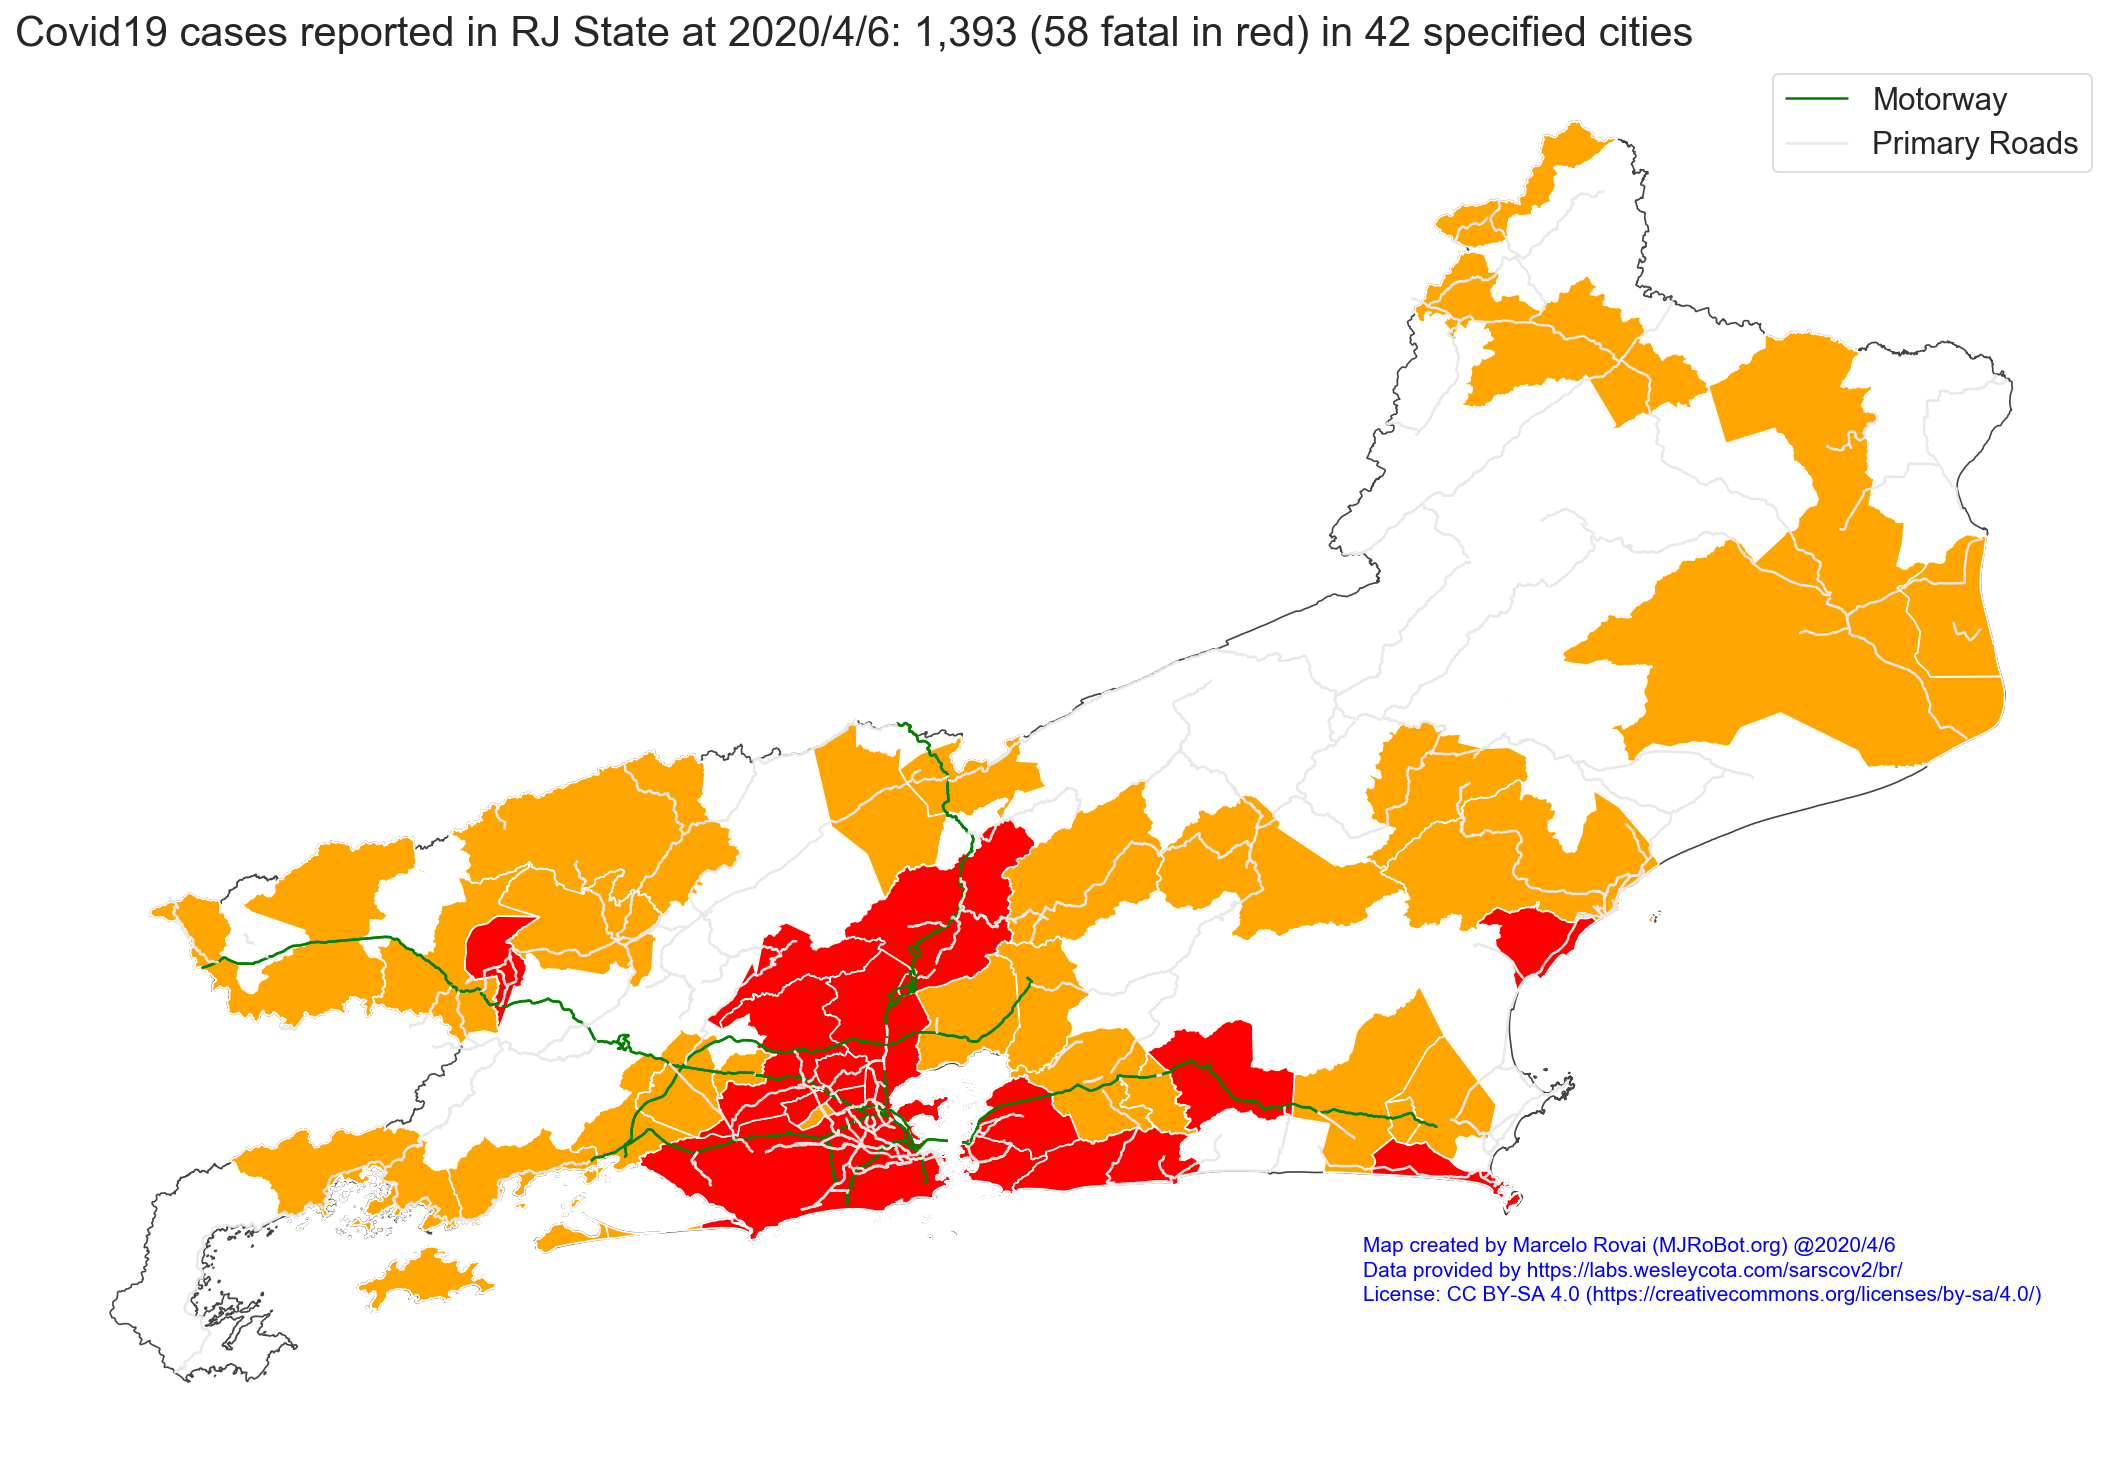

In [530]:
cv_rj, deaths_rj, rj_total_cases, rj_deaths = get_state_info(cv_city, 'RJ')

Total number of Covid19 cases reported in MG State at 4/6: 491 (6 fatal) in 52 specified cities


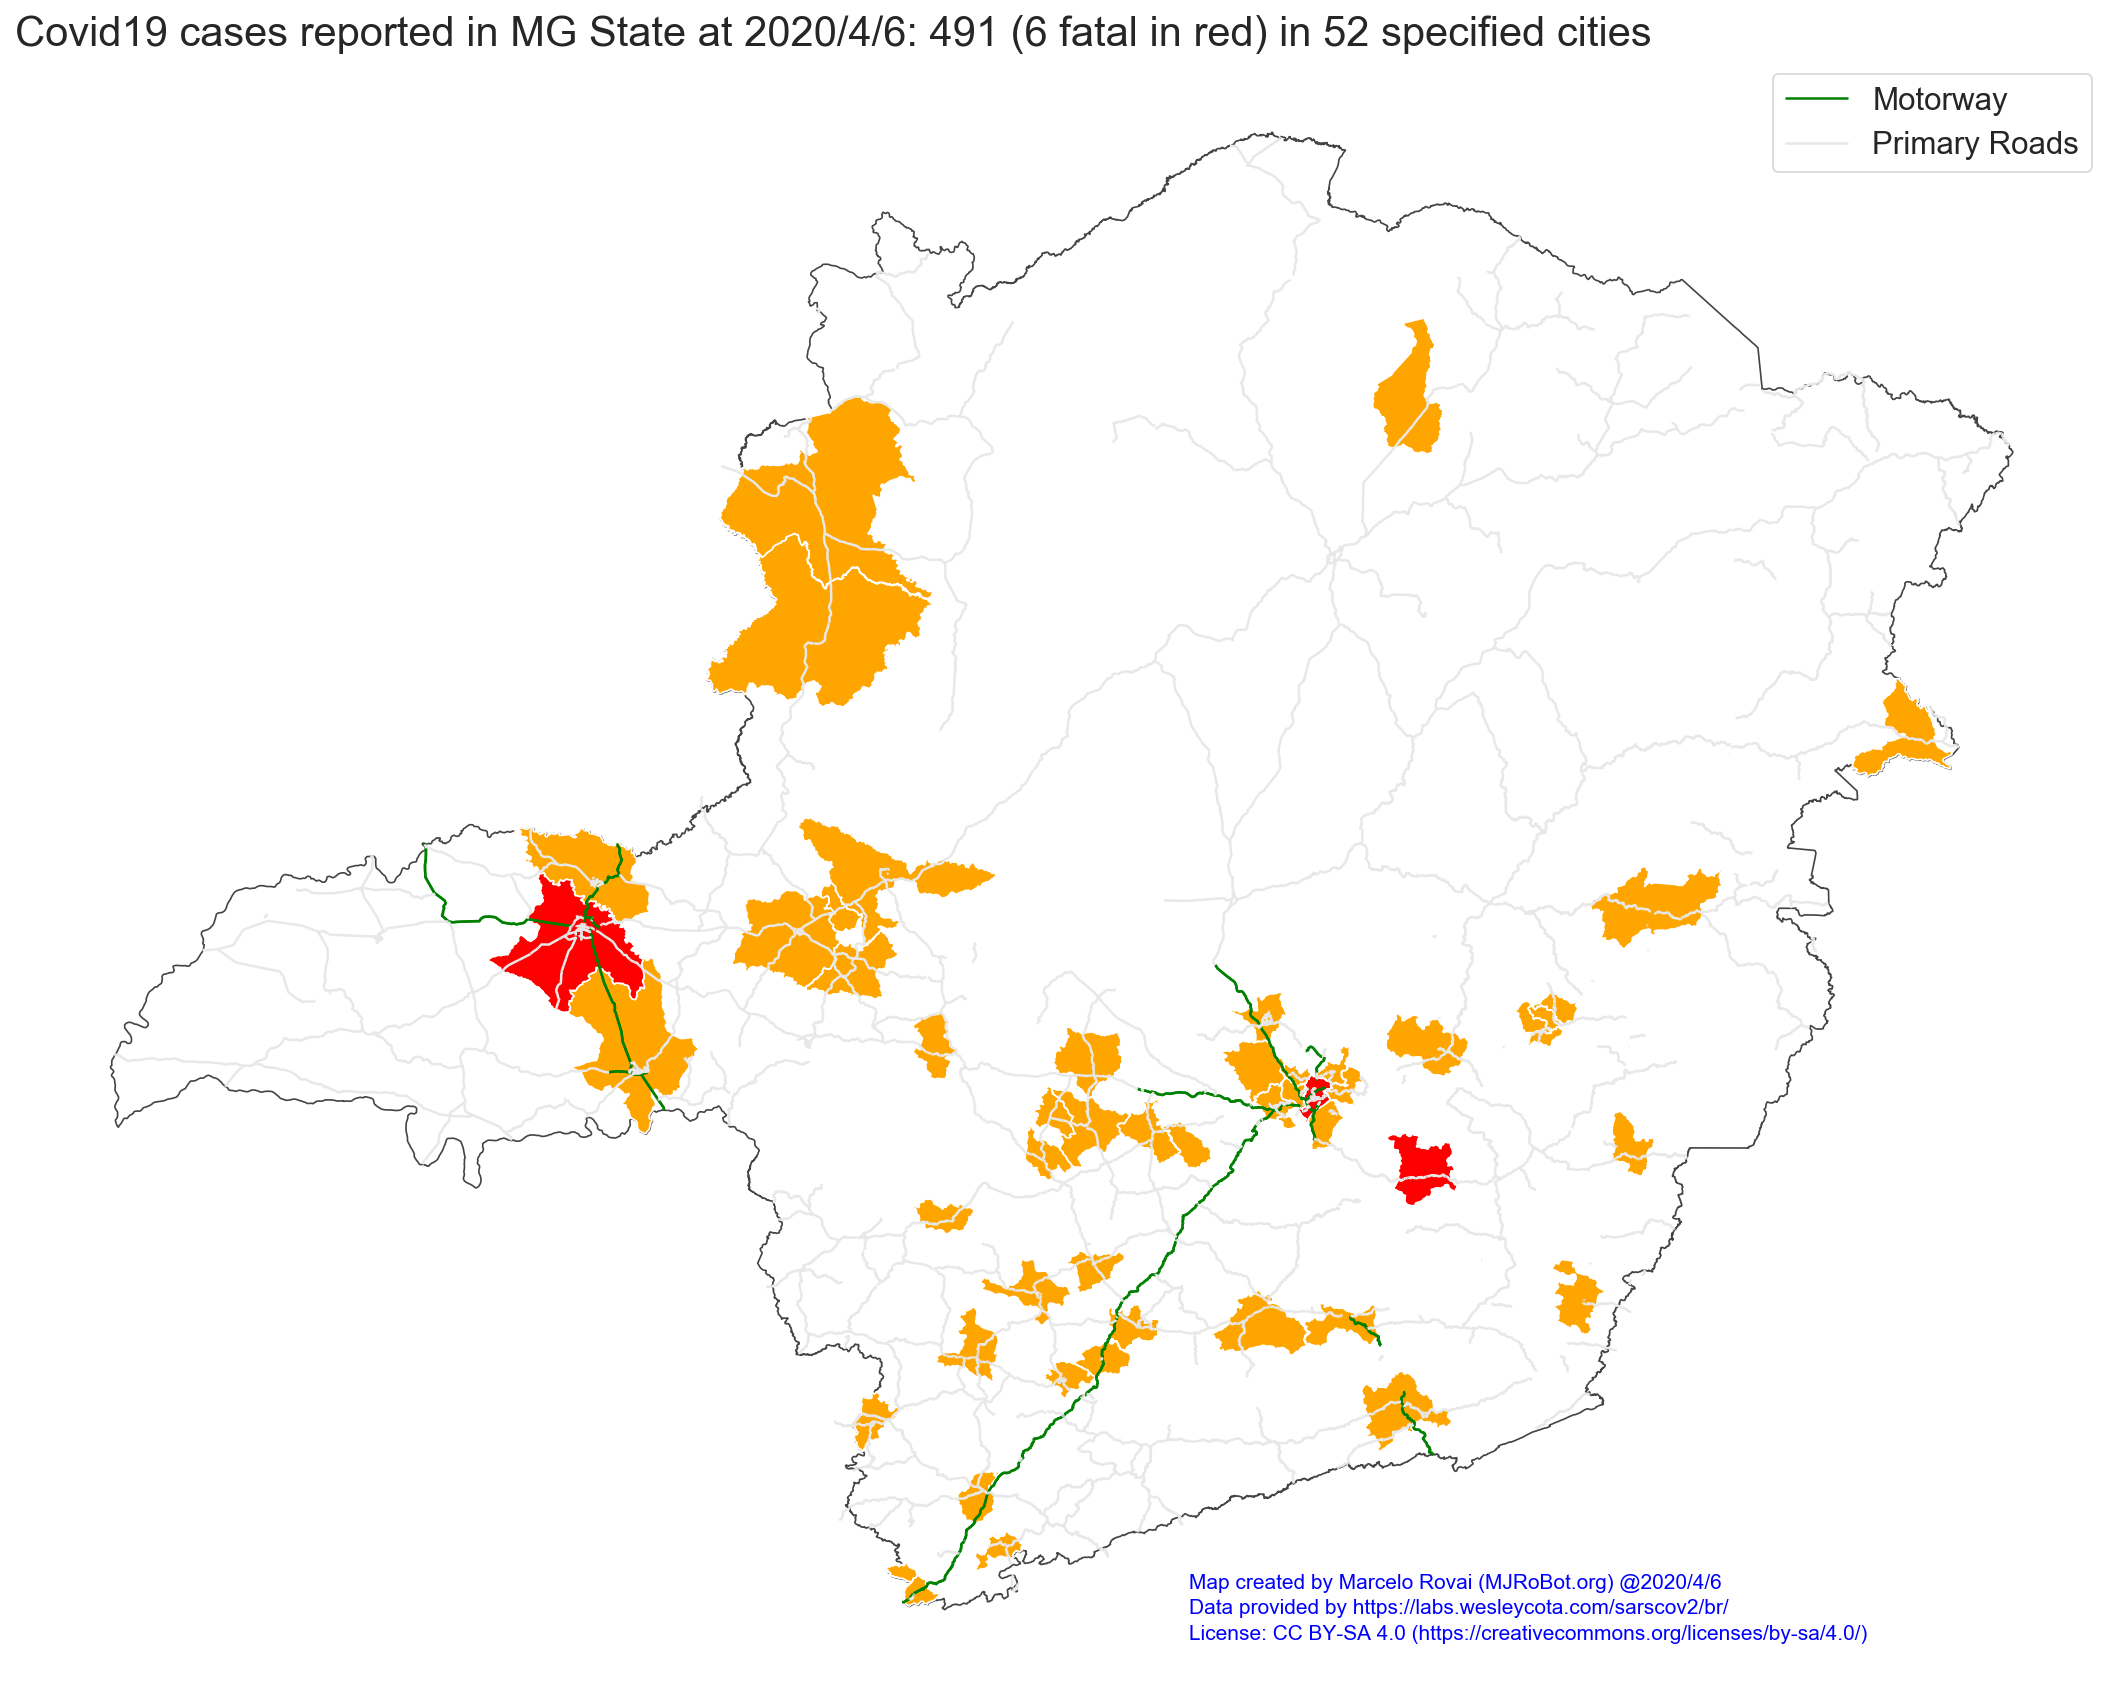

In [531]:
cv_mg, deaths_mg, mg_total_cases, mg_deaths = get_state_info(cv_city, 'MG')

Total number of Covid19 cases reported in CE State at 4/6: 755 (22 fatal) in 23 specified cities


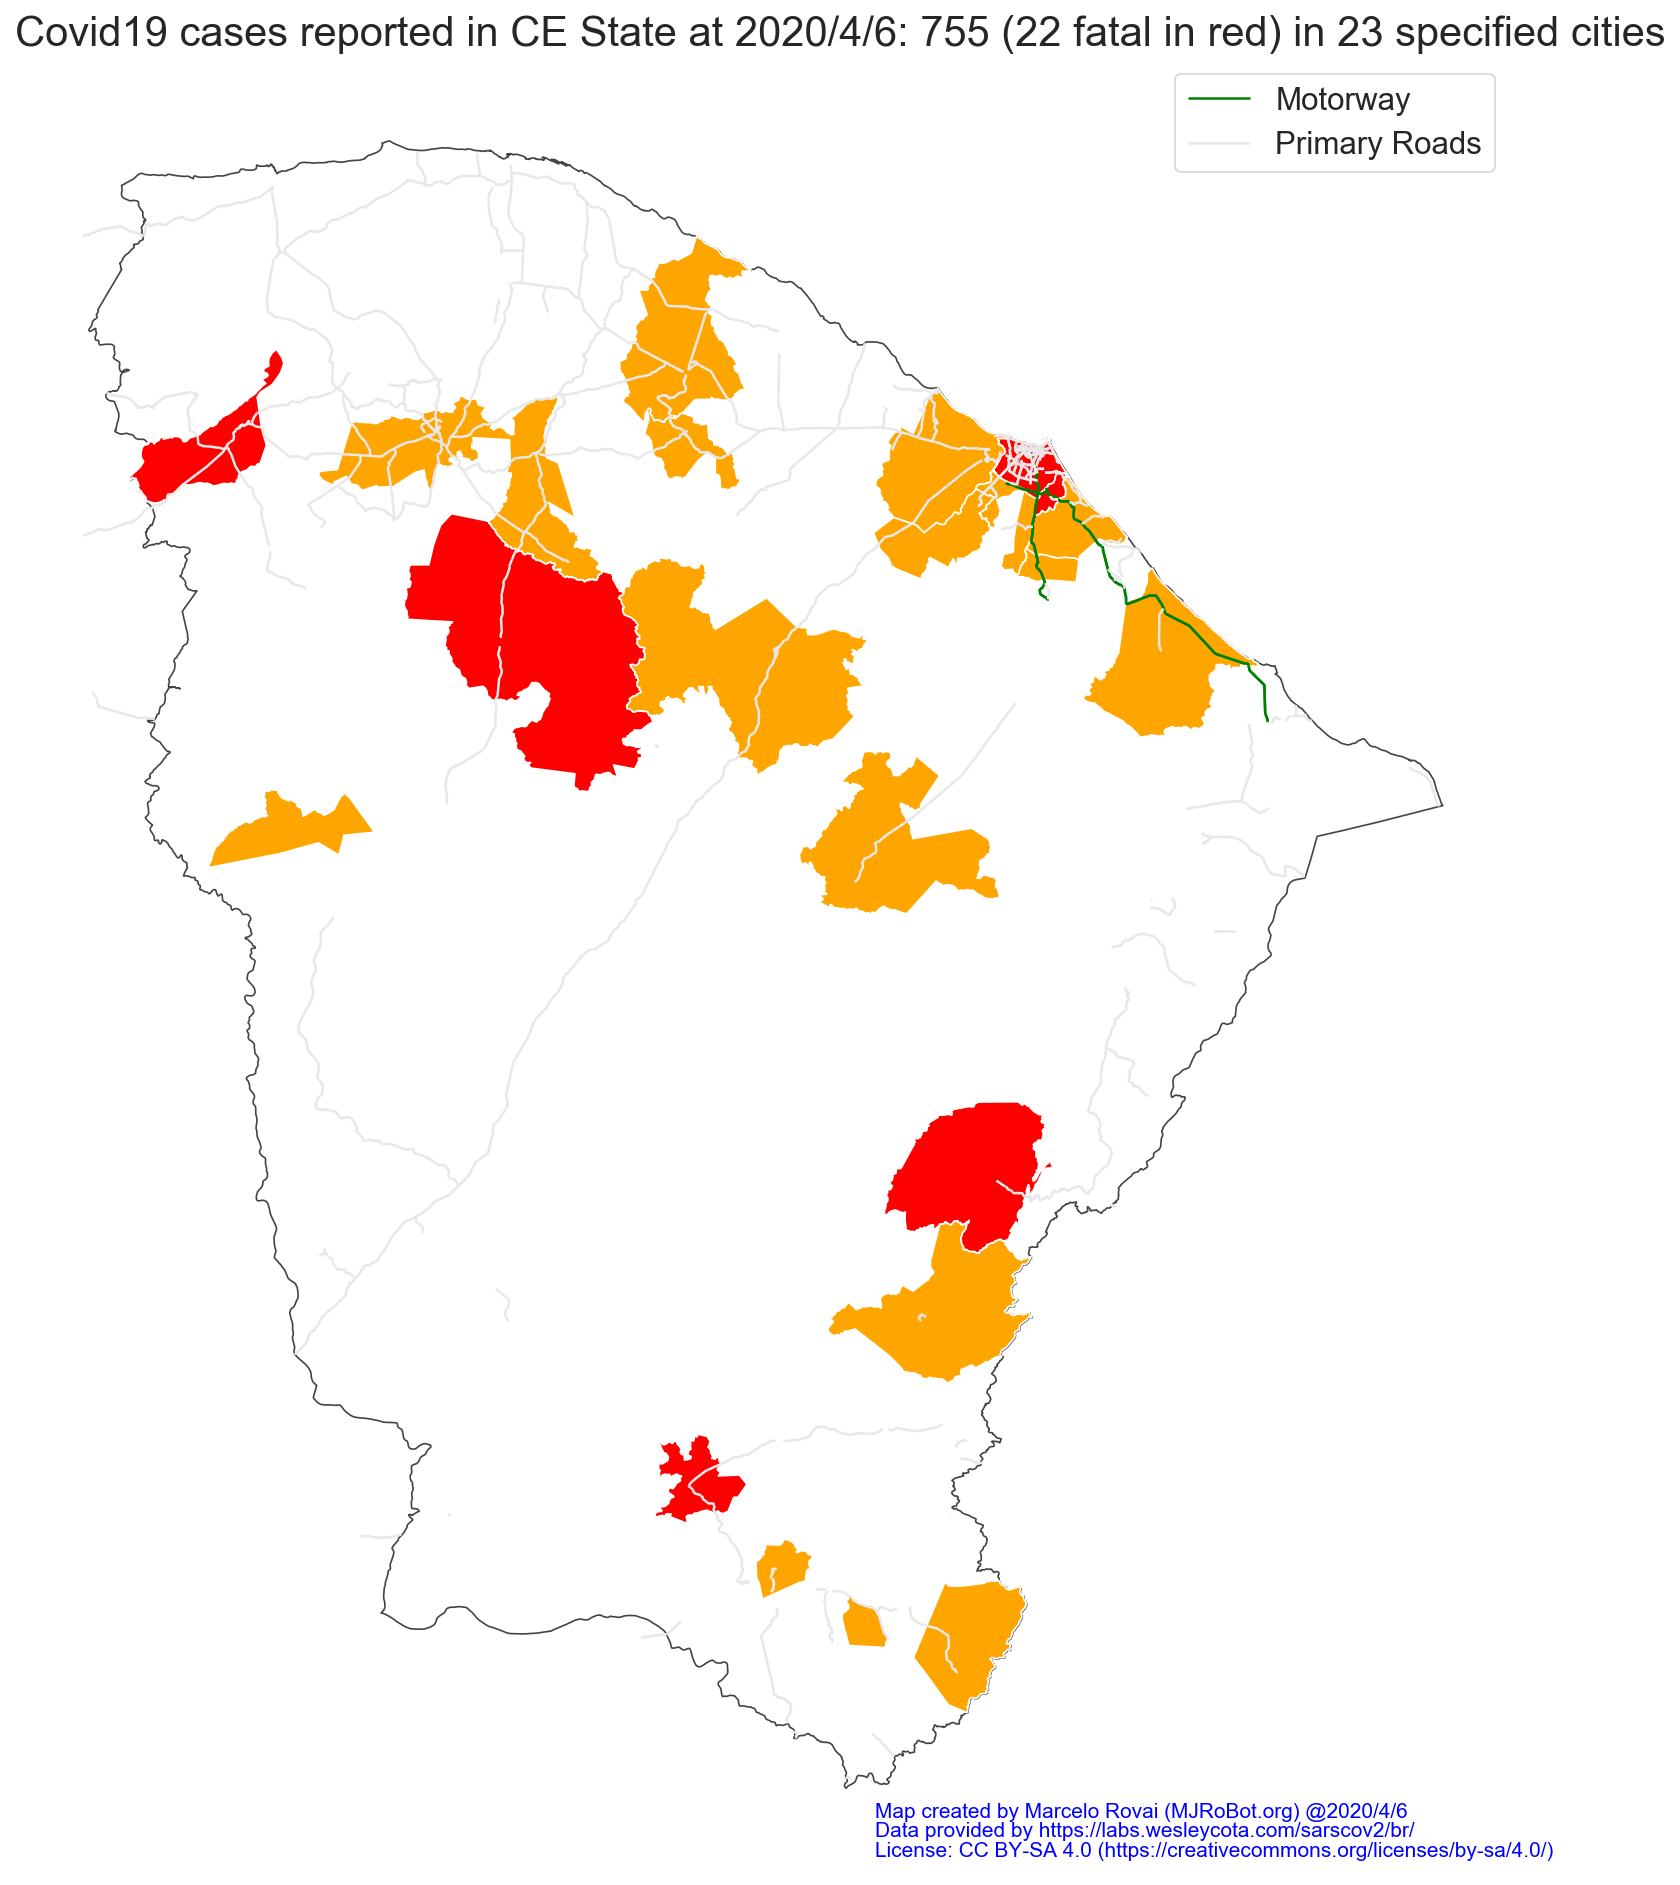

In [532]:
cv_ce, deaths_ce, ce_total_cases, ce_deaths = get_state_info(cv_city, 'CE')

### Analysis 

In [541]:
dtest = cv_city_pnt.sort_values('totalCases', ascending=False).copy()
dtest = dtest[[
    'NOME DO MUNICÍPIO', 'UF', 'POPULAÇÃO ESTIMADA', 'AREA [KMˆ2]',
    'DENS. DEMOG. [hab/kmˆ2]', 'totalCases'
]]

In [542]:
dtest.rename(columns={'totalCases':'TOTAL CASOS'}, inplace=True)

In [543]:
dtest[:20]

NOME DO MUNICÍPIO  UF  POPULAÇÃO ESTIMADA  AREA [KMˆ2]  \
0                São Paulo  SP            12252023      1,810.9   
4           Rio de Janeiro  RJ             6718903     1,413.47   
36               Fortaleza  CE             2669342       313.77   
5                 Brasília  DF             3015268     6,217.88   
23                  Manaus  AM             2182763    11,425.25   
40          Belo Horizonte  MG             2512070       374.55   
11            Porto Alegre  RS             1483771       660.68   
22                Salvador  BA             2872347       729.83   
14                Curitiba  PR             1933105       533.15   
12                  Recife  PE             1645727       223.18   
110               São Luís  MA             1101884        584.2   
17           Florianópolis  SC              500973       857.71   
9                  Niterói  RJ              513584        157.5   
34   São Bernardo do Campo  SP              838936       488.76   
21                   Natal  RN              884122       169.12   
20                 Goiânia  GO             1516113       793.54   
340                 Santos  SP              433311       335.69   
47             Santo André  SP              718773       209.52   
114                 Osasco  SP              698418        77.19   
31                 Vitória  ES              362097       110.33   

     DENS. DEMOG. [hab/kmˆ2]  TOTAL CASOS  
0                   6,765.71         3612  
4                   4,753.48         1068  
36                  8,507.32          704  
5                     484.94          468  
23                    191.05          379  
40                   6,706.9          262  
11                  2,245.82          254  
22                  3,935.64          244  
14                  3,625.82          172  
12                  7,373.99          139  
110                 1,886.14          121  
17                    584.08           94  
9                   3,260.85           87  
34                  1,716.46           81  
21                  5,227.78           77  
20                  1,910.57           73  
340                 1,290.81           72  
47                  3,430.57           72  
114                 9,048.04           69  
31                  3,281.95           62

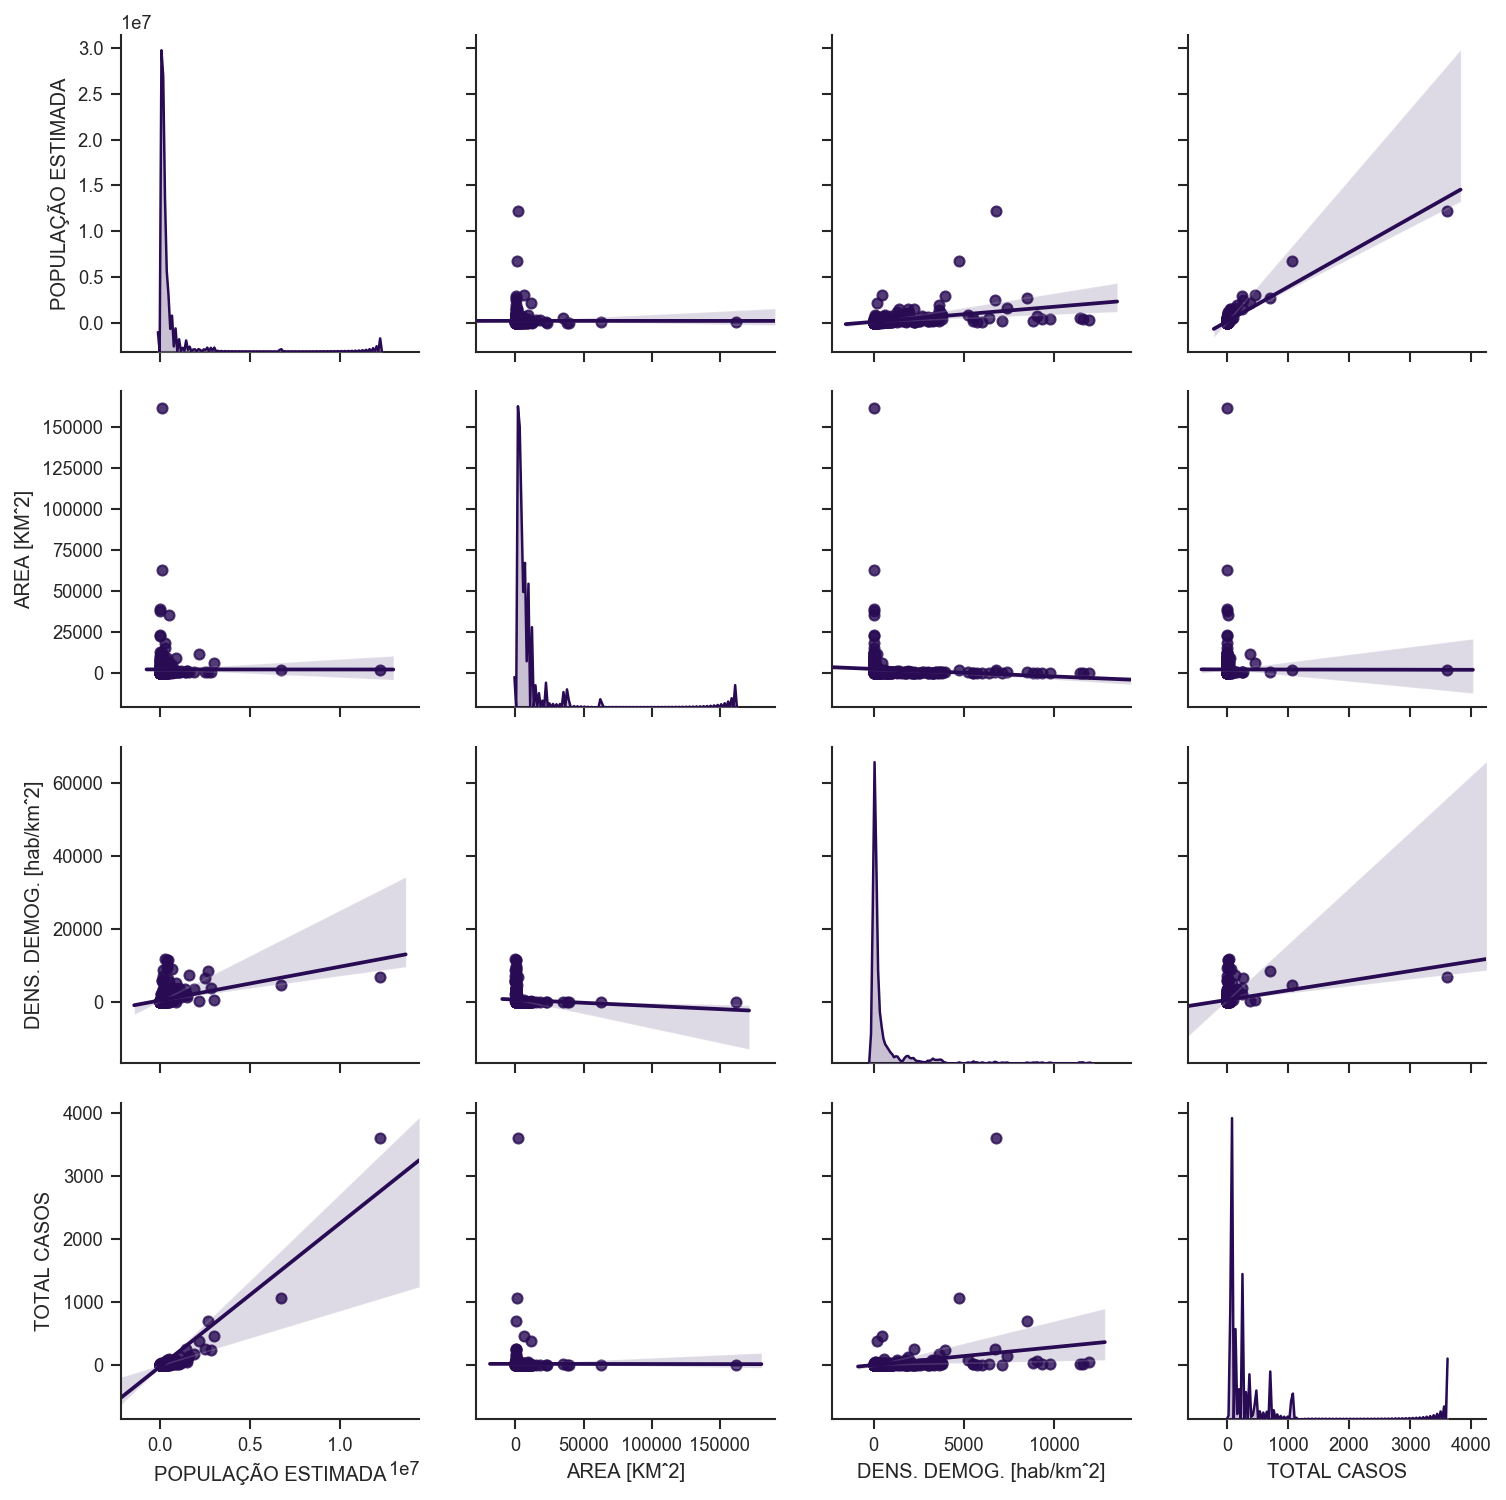

In [544]:
sns.pairplot(dtest, diag_kind="kde", kind="reg");
file = '../images/cv19_PairPlot_'+str(date.month)+'-'+str(date.day)+'-'+str(date.year)+'.png'
plt.savefig(file)

## Creating  GIFs

In [551]:
cv_city_t = pd.merge(dt_tm_city, br_cities, on='COD. IBGE')
cv_city_t = gpd.GeoDataFrame(cv_city_t, crs='4326')

In [552]:
cv_city_t.head(2)

date country state          city  COD. IBGE  newCases  totalCases  \
0  2020-02-25  Brazil    SP  São Paulo/SP    3550308         1           1   
1  2020-02-29  Brazil    SP  São Paulo/SP    3550308         1           2   

   UF  COD. UF NOME DO MUNICÍPIO  POPULAÇÃO ESTIMADA  AREA [KMˆ2]  \
0  SP       35         São Paulo            12252023      1,810.9   
1  SP       35         São Paulo            12252023      1,810.9   

                                            geometry  DENS. DEMOG. [hab/kmˆ2]  \
0  POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...                 6,765.71   
1  POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...                 6,765.71   

            LATITUDE           LONGITUDE  
0 -23.68230799899996 -46.716985836778605  
1 -23.68230799899996 -46.716985836778605

In [553]:
dates = list(set(cv_city_t.date))
dates.sort()

In [554]:
dates

['2020-02-25',
 '2020-02-29',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05']

In [ ]:
for date in dates:
    ax = br_state.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
    fdtt = cv_city_t.loc[cv_city_t['date'] == date].copy()
    fdtt.plot(ax=ax, color="orange", markersize=5, label='City')
    plt.title('Brazilian cities reported with Covid19 cases', fontsize=30)
    
    for idx, row in br_state.iterrows():
        plt.annotate(s=row['UF'],
                     xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                     horizontalalignment='center',
                     fontsize=10,
                     color='green')
        
    plt.annotate('Date:         {}'.format(date),
                 xy=(0.7, .85),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=25)

    plt.annotate('Total Cases:        {}'.format(str(fdtt.totalCases.sum())),
                 xy=(0.7, .82),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=25)
    
    plt.annotate('Number of Cities:  {}'.format(str(len(fdtt.index))),
                 xy=(0.7, .79),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=25)
    
    plt.annotate('Map created by Marcelo Rovai (MJRoBot.org)',
                 xy=(0.55, .17),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
                 xy=(0.55, .16),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')
    plt.annotate('License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/',
                 xy=(0.55, .15),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 fontsize=12,
                 color='blue')    
    
    plt.axis('off')
    file = '../br_images_gif/cv19_Brazil_' + str(date) + '.png'
    plt.savefig(file, dpi=150)

In [578]:
from PIL import Image
import glob

# Create the frames
frames = []
imgs = sorted(glob.glob('../br_images_gif/*.png'))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

frames[0].save('../images/Brasil_Covid-19_Timeline.gif',
               format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=500,
               loop=1)

COVID-19
<img src="../images/Brasil_Covid-19_Timeline.gif">

### GIF per selected States

In [383]:
cv_state_t = cv_city_t.loc[cv_city_t['state'] == 'SP'].copy()
cv_state_t.head(2)

date country state          city  COD. IBGE  newCases  totalCases  \
0  2020-02-25  Brazil    SP  São Paulo/SP    3550308         1           1   
1  2020-02-29  Brazil    SP  São Paulo/SP    3550308         1           2   

   UF  COD. UF NOME DO MUNICÍPIO  POPULAÇÃO ESTIMADA  AREA [KMˆ2]  \
0  SP       35         São Paulo            12252023      1,810.9   
1  SP       35         São Paulo            12252023      1,810.9   

                                            geometry  DENS. DEMOG. [hab/kmˆ2]  \
0  POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...                 6,765.71   
1  POLYGON ((-46.46934 -23.48106, -46.46885 -23.4...                 6,765.71   

            LATITUDE           LONGITUDE  
0 -23.68230799899996 -46.716985836778605  
1 -23.68230799899996 -46.716985836778605

In [ ]:
for date in dates:
    ax = sp_shp.plot(figsize=(18, 16), color='#FFFFFF', edgecolor='#444444')
    sp_motorway.plot(ax=ax, color="green", markersize=1, label = 'Motorway')
    sp_primary.plot(ax=ax, color="#E8E8E8", markersize=1, label = 'Primary Roads')
    fdtt = cv_state_t.loc[cv_state_t['date'] == date].copy()
    fdtt.plot(ax=ax, color="orange", markersize=5, label='City')
    plt.title('São Paulo State (SP) cities reported with Covid19 cases', fontsize=30)
    
    xy_1 = (-47.2, -25)
    xy_2 = (-47.2, -25.1)
    xy_3 = (-47.2, -25.2)
        
    plt.annotate('Date:         {}'.format(date),
                 xy=(0.7, .72),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=25)

    plt.annotate('Total Cases:        {}'.format(str(fdtt.totalCases.sum())),
                 xy=(0.7, .69),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=25)
    
    plt.annotate('Number of Cities:  {}'.format(str(len(fdtt.index))),
                 xy=(0.7, .66),
                 xycoords='figure fraction',
                 horizontalalignment='left',
                 verticalalignment='top',
                 fontsize=25)
    
    plt.annotate(
        'Map created by Marcelo Rovai (MJRoBot.org) ',
        xy=xy_1,
        fontsize=10,
        color='blue')
    plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
                 xy=xy_2,
                 fontsize=10,
                 color='blue')
    plt.annotate(
        'License: CC BY-SA 4.0 (https://creativecommons.org/licenses/by-sa/4.0/)',
        xy=xy_3,
        fontsize=10,
        color='blue')
    
#     plt.annotate('Visualization created by MJROVAI',
#                  xy=(0.58, .24),
#                  xycoords='figure fraction',
#                  horizontalalignment='left',
#                  fontsize=12,
#                  color='blue')
#     plt.annotate('Data provided by https://labs.wesleycota.com/sarscov2/br/',
#                  xy=(0.58, .23),
#                  xycoords='figure fraction',
#                  horizontalalignment='left',
#                  fontsize=12,
#                  color='blue')
    plt.axis('off')
    file = '../sp_images_gif/cv19_Brazil_' + str(date) + '.png'
    plt.savefig(file, dpi=200)

In [585]:
# Create the frames
frames = []
imgs = sorted(glob.glob('../sp_images_gif/*.png'))
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

frames[0].save('../images/SP_Covid-19_Timeline.gif',
               format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=500,
               loop=1)

COVID-19
<img src="../images/SP_Covid-19_Timeline.gif">